In [1]:
import keras
from keras.models import Sequential, Model, load_model

from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, LSTM, ConvLSTM2D, GRU, BatchNormalization, LocallyConnected2D, Permute
from keras.layers import Concatenate, Reshape, Softmax, Conv2DTranspose, Embedding, Multiply
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from keras import regularizers
from keras import backend as K
from keras.utils.generic_utils import Progbar
from keras.layers.merge import _Merge
import keras.losses

from functools import partial

from collections import defaultdict

import tensorflow as tf
from tensorflow.python.framework import ops

import isolearn.keras as iso

import numpy as np

import tensorflow as tf
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

import pandas as pd

import os
import pickle
import numpy as np

import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt

import isolearn.io as isoio
import isolearn.keras as isol

from genesis.visualization import *

from keras.backend.tensorflow_backend import set_session

def contain_tf_gpu_mem_usage() :
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tf.Session(config=config)
    set_session(sess)

contain_tf_gpu_mem_usage()

import os
import subprocess


Using TensorFlow backend.


In [2]:
from keras.layers import Layer, InputSpec
from keras import initializers, regularizers, constraints

class InstanceNormalization(Layer):
    """Instance normalization layer.
    Normalize the activations of the previous layer at each step,
    i.e. applies a transformation that maintains the mean activation
    close to 0 and the activation standard deviation close to 1.
    # Arguments
        axis: Integer, the axis that should be normalized
            (typically the features axis).
            For instance, after a `Conv2D` layer with
            `data_format="channels_first"`,
            set `axis=1` in `InstanceNormalization`.
            Setting `axis=None` will normalize all values in each
            instance of the batch.
            Axis 0 is the batch dimension. `axis` cannot be set to 0 to avoid errors.
        epsilon: Small float added to variance to avoid dividing by zero.
        center: If True, add offset of `beta` to normalized tensor.
            If False, `beta` is ignored.
        scale: If True, multiply by `gamma`.
            If False, `gamma` is not used.
            When the next layer is linear (also e.g. `nn.relu`),
            this can be disabled since the scaling
            will be done by the next layer.
        beta_initializer: Initializer for the beta weight.
        gamma_initializer: Initializer for the gamma weight.
        beta_regularizer: Optional regularizer for the beta weight.
        gamma_regularizer: Optional regularizer for the gamma weight.
        beta_constraint: Optional constraint for the beta weight.
        gamma_constraint: Optional constraint for the gamma weight.
    # Input shape
        Arbitrary. Use the keyword argument `input_shape`
        (tuple of integers, does not include the samples axis)
        when using this layer as the first layer in a Sequential model.
    # Output shape
        Same shape as input.
    # References
        - [Layer Normalization](https://arxiv.org/abs/1607.06450)
        - [Instance Normalization: The Missing Ingredient for Fast Stylization](
        https://arxiv.org/abs/1607.08022)
    """
    def __init__(self,
                 axis=None,
                 epsilon=1e-3,
                 center=True,
                 scale=True,
                 beta_initializer='zeros',
                 gamma_initializer='ones',
                 beta_regularizer=None,
                 gamma_regularizer=None,
                 beta_constraint=None,
                 gamma_constraint=None,
                 **kwargs):
        super(InstanceNormalization, self).__init__(**kwargs)
        self.supports_masking = True
        self.axis = axis
        self.epsilon = epsilon
        self.center = center
        self.scale = scale
        self.beta_initializer = initializers.get(beta_initializer)
        self.gamma_initializer = initializers.get(gamma_initializer)
        self.beta_regularizer = regularizers.get(beta_regularizer)
        self.gamma_regularizer = regularizers.get(gamma_regularizer)
        self.beta_constraint = constraints.get(beta_constraint)
        self.gamma_constraint = constraints.get(gamma_constraint)

    def build(self, input_shape):
        ndim = len(input_shape)
        if self.axis == 0:
            raise ValueError('Axis cannot be zero')

        if (self.axis is not None) and (ndim == 2):
            raise ValueError('Cannot specify axis for rank 1 tensor')

        self.input_spec = InputSpec(ndim=ndim)

        if self.axis is None:
            shape = (1,)
        else:
            shape = (input_shape[self.axis],)

        if self.scale:
            self.gamma = self.add_weight(shape=shape,
                                         name='gamma',
                                         initializer=self.gamma_initializer,
                                         regularizer=self.gamma_regularizer,
                                         constraint=self.gamma_constraint)
        else:
            self.gamma = None
        if self.center:
            self.beta = self.add_weight(shape=shape,
                                        name='beta',
                                        initializer=self.beta_initializer,
                                        regularizer=self.beta_regularizer,
                                        constraint=self.beta_constraint)
        else:
            self.beta = None
        self.built = True

    def call(self, inputs, training=None):
        input_shape = K.int_shape(inputs)
        reduction_axes = list(range(0, len(input_shape)))

        if self.axis is not None:
            del reduction_axes[self.axis]

        del reduction_axes[0]

        mean = K.mean(inputs, reduction_axes, keepdims=True)
        stddev = K.std(inputs, reduction_axes, keepdims=True) + self.epsilon
        normed = (inputs - mean) / stddev

        broadcast_shape = [1] * len(input_shape)
        if self.axis is not None:
            broadcast_shape[self.axis] = input_shape[self.axis]

        if self.scale:
            broadcast_gamma = K.reshape(self.gamma, broadcast_shape)
            normed = normed * broadcast_gamma
        if self.center:
            broadcast_beta = K.reshape(self.beta, broadcast_shape)
            normed = normed + broadcast_beta
        return normed

    def get_config(self):
        config = {
            'axis': self.axis,
            'epsilon': self.epsilon,
            'center': self.center,
            'scale': self.scale,
            'beta_initializer': initializers.serialize(self.beta_initializer),
            'gamma_initializer': initializers.serialize(self.gamma_initializer),
            'beta_regularizer': regularizers.serialize(self.beta_regularizer),
            'gamma_regularizer': regularizers.serialize(self.gamma_regularizer),
            'beta_constraint': constraints.serialize(self.beta_constraint),
            'gamma_constraint': constraints.serialize(self.gamma_constraint)
        }
        base_config = super(InstanceNormalization, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


In [2]:
#Load APA plasmid data (random mpra)
plasmid_dict = pickle.load(open('../../../../aparent/apa_plasmid_data.pickle', 'rb'))

plasmid_df = plasmid_dict['plasmid_df']
plasmid_cuts = plasmid_dict['plasmid_cuts']

print("len(plasmid_df) = " + str(len(plasmid_df)))


len(plasmid_df) = 3810974


In [3]:
#Filter data
kept_libraries = [22]

min_count = 40#50
min_usage = 0.9

if kept_libraries is not None :
    keep_index = np.nonzero(plasmid_df.library_index.isin(kept_libraries))[0]
    plasmid_df = plasmid_df.iloc[keep_index].copy()
    plasmid_cuts = plasmid_cuts[keep_index, :]

if min_count is not None :
    keep_index = np.nonzero(plasmid_df.total_count >= min_count)[0]
    plasmid_df = plasmid_df.iloc[keep_index].copy()
    plasmid_cuts = plasmid_cuts[keep_index, :]

if min_usage is not None :
    
    prox_c = np.ravel(plasmid_cuts[:, 180+70+6:180+70+6+35].sum(axis=-1))
    total_c = np.ravel(plasmid_cuts[:, 180:180+205].sum(axis=-1)) + np.ravel(plasmid_cuts[:, -1].todense())
    
    keep_index = np.nonzero(prox_c / total_c >= min_usage)[0]
    plasmid_df = plasmid_df.iloc[keep_index].copy()
    plasmid_cuts = plasmid_cuts[keep_index, :]

print("len(plasmid_df) = " + str(len(plasmid_df)) + " (filtered)")


len(plasmid_df) = 95749 (filtered)


In [3]:
#Store cached filtered dataframe
#pickle.dump({'plasmid_df' : plasmid_df, 'plasmid_cuts' : plasmid_cuts}, open('apa_simple_cached_set_large.pickle', 'wb'))

#Load cached dataframe
cached_dict = pickle.load(open('apa_simple_cached_set_large.pickle', 'rb'))
plasmid_df = cached_dict['plasmid_df']
plasmid_cuts = cached_dict['plasmid_cuts']

print("len(plasmid_df) = " + str(len(plasmid_df)) + " (loaded)")


len(plasmid_df) = 95749 (loaded)


In [4]:
#Make generators

valid_set_size = 0.05
test_set_size = 0.05

batch_size = 32

#Generate training and test set indexes
plasmid_index = np.arange(len(plasmid_df), dtype=np.int)

plasmid_train_index = plasmid_index[:-int(len(plasmid_df) * (valid_set_size + test_set_size))]
plasmid_valid_index = plasmid_index[plasmid_train_index.shape[0]:-int(len(plasmid_df) * test_set_size)]
plasmid_test_index = plasmid_index[plasmid_train_index.shape[0] + plasmid_valid_index.shape[0]:]

print('Training set size = ' + str(plasmid_train_index.shape[0]))
print('Validation set size = ' + str(plasmid_valid_index.shape[0]))
print('Test set size = ' + str(plasmid_test_index.shape[0]))


data_gens = {
    gen_id : iso.DataGenerator(
        idx,
        {'df' : plasmid_df},
        batch_size=batch_size,
        inputs = [
            {
                'id' : 'seq',
                'source_type' : 'dataframe',
                'source' : 'df',
                'extractor' : iso.SequenceExtractor('padded_seq', start_pos=180, end_pos=180 + 205),
                'encoder' : iso.OneHotEncoder(seq_length=205),
                'dim' : (1, 205, 4),
                'sparsify' : False
            }
        ],
        outputs = [
            {
                'id' : 'dummy_output',
                'source_type' : 'zeros',
                'dim' : (1,),
                'sparsify' : False
            }
        ],
        randomizers = [],
        shuffle = True if gen_id == 'train' else False,
        densify_batch_matrices=True
    ) for gen_id, idx in [('all', plasmid_index), ('train', plasmid_train_index), ('valid', plasmid_valid_index), ('test', plasmid_test_index)]
}


Training set size = 86175
Validation set size = 4787
Test set size = 4787


In [5]:
def make_gen_resblock(n_channels=64, window_size=8, dilation_rate=1, group_ix=0, layer_ix=0) :

    #Initialize res block layers
    batch_norm_0 = InstanceNormalization(axis=-1, name='policy_generator_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_batch_norm_0')

    relu_0 = Lambda(lambda x: K.relu(x))

    conv_0 = Conv2D(n_channels, (1, window_size), dilation_rate=dilation_rate, strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='policy_generator_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_conv_0')

    batch_norm_1 = InstanceNormalization(axis=-1, name='policy_generator_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_batch_norm_1')

    relu_1 = Lambda(lambda x: K.relu(x))

    conv_1 = Conv2D(n_channels, (1, window_size), dilation_rate=dilation_rate, strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='policy_generator_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_conv_1')

    skip_1 = Lambda(lambda x: x[0] + x[1], name='policy_generator_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_skip_1')

    #Execute res block
    def _resblock_func(input_tensor, training=True) :
        batch_norm_0_out = batch_norm_0(input_tensor, training=training)
        relu_0_out = relu_0(batch_norm_0_out)
        conv_0_out = conv_0(relu_0_out)

        batch_norm_1_out = batch_norm_1(conv_0_out, training=training)
        relu_1_out = relu_1(batch_norm_1_out)
        conv_1_out = conv_1(relu_1_out)

        skip_1_out = skip_1([conv_1_out, input_tensor])
        
        return skip_1_out

    return _resblock_func


#GAN Generator Model definition
def load_generator_network_4_resblocks(batch_size, seq_length=205) :

    #Generator network parameters
    latent_size = 100
    n_resblocks = 4
    n_channels = 32

    #Policy network definition
    policy_dense_0 = Dense(21 * 384, activation='linear', kernel_initializer='glorot_uniform', name='policy_generator_dense_0')

    policy_dense_0_reshape = Reshape((1, 21, 384))

    policy_deconv_0 = Conv2DTranspose(256, (1, 7), strides=(1, 2), padding='valid', activation='linear', kernel_initializer='glorot_normal', name='policy_generator_deconv_0')

    policy_deconv_1 = Conv2DTranspose(192, (1, 8), strides=(1, 2), padding='valid', activation='linear', kernel_initializer='glorot_normal', name='policy_generator_deconv_1')

    policy_deconv_2 = Conv2DTranspose(128, (1, 7), strides=(1, 2), padding='valid', activation='linear', kernel_initializer='glorot_normal', name='policy_generator_deconv_2')

    policy_conv_3 = Conv2D(n_channels, (1, 1), strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='policy_generator_conv_3')

    batch_norm_dense_0 = InstanceNormalization(axis=-1, name='policy_generator_batch_norm_dense_0')
    relu_dense_0 = Lambda(lambda x: K.relu(x))

    batch_norm_0 = InstanceNormalization(axis=-1, name='policy_generator_batch_norm_0')
    relu_0 = Lambda(lambda x: K.relu(x))
    batch_norm_1 = InstanceNormalization(axis=-1, name='policy_generator_batch_norm_1')
    relu_1 = Lambda(lambda x: K.relu(x))
    batch_norm_2 = InstanceNormalization(axis=-1, name='policy_generator_batch_norm_2')
    relu_2 = Lambda(lambda x: K.relu(x))
    
    skip_conv_0 = Conv2D(n_channels, (1, 1), strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='policy_generator_skip_conv_0')
    
    resblocks = []
    for layer_ix in range(n_resblocks) :
        resblocks.append(make_gen_resblock(n_channels=n_channels, window_size=8, dilation_rate=1, group_ix=0, layer_ix=layer_ix))
    
    last_block_conv = Conv2D(n_channels, (1, 1), strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='policy_generator_last_block_conv')
    
    skip_add = Lambda(lambda x: x[0] + x[1], name='policy_generator_skip_add')
    
    final_conv = Conv2D(4, (1, 1), strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='policy_generator_final_conv')
    
    def _generator_func(seed_input, training=True) :
        relu_dense_0_out = relu_dense_0(batch_norm_dense_0(policy_dense_0_reshape(policy_dense_0(seed_input)), training=training))
        
        policy_relu_0_out = relu_0(batch_norm_0(policy_deconv_0(relu_dense_0_out), training=training))
        policy_relu_1_out = relu_1(batch_norm_1(policy_deconv_1(policy_relu_0_out), training=training))
        policy_relu_2_out = relu_2(batch_norm_2(policy_deconv_2(policy_relu_1_out), training=training))

        policy_conv_3_out = policy_conv_3(policy_relu_2_out)

        #Connect group of res blocks
        output_tensor = policy_conv_3_out

        #Res block group 0
        skip_conv_0_out = skip_conv_0(output_tensor)

        for layer_ix in range(n_resblocks) :
            output_tensor = resblocks[layer_ix](output_tensor, training=training)

        #Last res block extr conv
        last_block_conv_out = last_block_conv(output_tensor)

        skip_add_out = skip_add([last_block_conv_out, skip_conv_0_out])

        #Final conv out
        final_conv_out = final_conv(skip_add_out)
        
        return final_conv_out

    return _generator_func

def load_generator_network_8_resblocks(batch_size, seq_length=205) :

    #Generator network parameters
    latent_size = 100
    n_resblocks = 4
    n_channels = 32

    #Policy network definition
    policy_dense_0 = Dense(21 * 384, activation='linear', kernel_initializer='glorot_uniform', name='policy_generator_dense_0')

    policy_dense_0_reshape = Reshape((1, 21, 384))

    policy_deconv_0 = Conv2DTranspose(256, (1, 7), strides=(1, 2), padding='valid', activation='linear', kernel_initializer='glorot_normal', name='policy_generator_deconv_0')

    policy_deconv_1 = Conv2DTranspose(192, (1, 8), strides=(1, 2), padding='valid', activation='linear', kernel_initializer='glorot_normal', name='policy_generator_deconv_1')

    policy_deconv_2 = Conv2DTranspose(128, (1, 7), strides=(1, 2), padding='valid', activation='linear', kernel_initializer='glorot_normal', name='policy_generator_deconv_2')

    policy_conv_3 = Conv2D(n_channels, (1, 1), strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='policy_generator_conv_3')

    batch_norm_dense_0 = InstanceNormalization(axis=-1, name='policy_generator_batch_norm_dense_0')
    relu_dense_0 = Lambda(lambda x: K.relu(x))

    batch_norm_0 = InstanceNormalization(axis=-1, name='policy_generator_batch_norm_0')
    relu_0 = Lambda(lambda x: K.relu(x))
    batch_norm_1 = InstanceNormalization(axis=-1, name='policy_generator_batch_norm_1')
    relu_1 = Lambda(lambda x: K.relu(x))
    batch_norm_2 = InstanceNormalization(axis=-1, name='policy_generator_batch_norm_2')
    relu_2 = Lambda(lambda x: K.relu(x))
    
    #Res block group 0
    skip_conv_0 = Conv2D(n_channels, (1, 1), strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='policy_generator_skip_conv_0')
    
    resblocks_0 = []
    for layer_ix in range(n_resblocks) :
        resblocks_0.append(make_gen_resblock(n_channels=n_channels, window_size=8, dilation_rate=4, group_ix=0, layer_ix=layer_ix))
    
    #Res block group 1
    skip_conv_1 = Conv2D(n_channels, (1, 1), strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='policy_generator_skip_conv_1')
    
    resblocks_1 = []
    for layer_ix in range(n_resblocks) :
        resblocks_1.append(make_gen_resblock(n_channels=n_channels, window_size=8, dilation_rate=1, group_ix=1, layer_ix=layer_ix))
    
    
    last_block_conv = Conv2D(n_channels, (1, 1), strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='policy_generator_last_block_conv')
    
    skip_add = Lambda(lambda x: x[0] + x[1] + x[2], name='policy_generator_skip_add')
    
    final_conv = Conv2D(4, (1, 1), strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='policy_generator_final_conv')
    
    def _generator_func(seed_input, training=True) :
        relu_dense_0_out = relu_dense_0(batch_norm_dense_0(policy_dense_0_reshape(policy_dense_0(seed_input)), training=training))
        
        policy_relu_0_out = relu_0(batch_norm_0(policy_deconv_0(relu_dense_0_out), training=training))
        policy_relu_1_out = relu_1(batch_norm_1(policy_deconv_1(policy_relu_0_out), training=training))
        policy_relu_2_out = relu_2(batch_norm_2(policy_deconv_2(policy_relu_1_out), training=training))

        policy_conv_3_out = policy_conv_3(policy_relu_2_out)

        #Connect group of res blocks
        output_tensor = policy_conv_3_out

        #Res block group 0
        skip_conv_0_out = skip_conv_0(output_tensor)

        for layer_ix in range(n_resblocks) :
            output_tensor = resblocks_0[layer_ix](output_tensor, training=training)
        
        #Res block group 0
        skip_conv_1_out = skip_conv_1(output_tensor)

        for layer_ix in range(n_resblocks) :
            output_tensor = resblocks_1[layer_ix](output_tensor, training=training)

        #Last res block extr conv
        last_block_conv_out = last_block_conv(output_tensor)

        skip_add_out = skip_add([last_block_conv_out, skip_conv_0_out, skip_conv_1_out])

        #Final conv out
        final_conv_out = final_conv(skip_add_out)
        
        return final_conv_out

    return _generator_func


In [6]:

#GAN Discriminator Model definition
def load_discriminator_network_conv(batch_size, seq_length=205) :

    #Discriminator network definition
    policy_conv_0 = Conv2D(64, (1, 8), padding='valid', activation='linear', name='policy_discriminator_conv_0')
    relu_0 = Lambda(lambda x: K.relu(x, alpha=0.3))
    
    policy_conv_1 = Conv2D(96, (1, 8), padding='valid', activation='linear', name='policy_discriminator_conv_1')
    relu_1 = Lambda(lambda x: K.relu(x, alpha=0.3))
    
    policy_conv_2 = Conv2D(96, (1, 12), padding='valid', activation='linear', name='policy_discriminator_conv_2')
    relu_2 = Lambda(lambda x: K.relu(x, alpha=0.3))
    
    policy_flatten = Flatten()
    
    final_dense = Dense(1, activation='linear', kernel_initializer='glorot_uniform', name='policy_discriminator_final_dense')
    
    
    def _discriminator_func(sequence_input) :
        policy_relu_0_out = relu_0(policy_conv_0(sequence_input))
        policy_relu_1_out = relu_1(policy_conv_1(policy_relu_0_out))
        policy_relu_2_out = relu_2(policy_conv_2(policy_relu_1_out))
        
        policy_flatten_out = policy_flatten(policy_relu_2_out)
        
        #Final dense out
        final_dense_out = final_dense(policy_flatten_out)

        return final_dense_out

    return _discriminator_func

def load_discriminator_network_conv_hl(batch_size, seq_length=205) :
    
    drop_rate = 0.25
    
    #Discriminator network definition
    policy_conv_0 = Conv2D(64, (1, 8), padding='valid', activation='linear', name='policy_discriminator_conv_0')
    relu_0 = Lambda(lambda x: K.relu(x, alpha=0.3))
    
    policy_conv_1 = Conv2D(96, (1, 8), padding='valid', activation='linear', name='policy_discriminator_conv_1')
    relu_1 = Lambda(lambda x: K.relu(x, alpha=0.3))
    
    policy_conv_2 = Conv2D(96, (1, 12), padding='valid', activation='linear', name='policy_discriminator_conv_2')
    relu_2 = Lambda(lambda x: K.relu(x, alpha=0.3))
    
    policy_flatten = Flatten()
    
    policy_dense_0 = Dense(64, activation='linear', name='policy_discriminator_dense_0')
    relu_dense_0 = Lambda(lambda x: K.relu(x, alpha=0.3))
    
    drop_dense_0 = Dropout(drop_rate)
    
    final_dense = Dense(1, activation='linear', kernel_initializer='glorot_uniform', name='policy_discriminator_final_dense')
    
    def _discriminator_func(sequence_input) :
        policy_relu_0_out = relu_0(policy_conv_0(sequence_input))
        policy_relu_1_out = relu_1(policy_conv_1(policy_relu_0_out))
        policy_relu_2_out = relu_2(policy_conv_2(policy_relu_1_out))
        
        policy_flatten_out = policy_flatten(policy_relu_2_out)
        
        policy_dense_0_out = drop_dense_0(relu_dense_0(policy_dense_0(policy_flatten_out)), training=True)

        #Final dense out
        final_dense_out = final_dense(policy_dense_0_out)

        return final_dense_out

    return _discriminator_func

def load_discriminator_network_conv_max_pool(batch_size, seq_length=205) :

    #Discriminator network definition
    policy_conv_0 = Conv2D(64, (1, 8), padding='valid', activation='linear', name='policy_discriminator_conv_0')
    relu_0 = Lambda(lambda x: K.relu(x, alpha=0.3))
    
    max_pool_0 = MaxPooling2D(pool_size=(1, 2))
    
    policy_conv_1 = Conv2D(96, (1, 6), padding='valid', activation='linear', name='policy_discriminator_conv_1')
    relu_1 = Lambda(lambda x: K.relu(x, alpha=0.3))
    
    policy_flatten = Flatten()
    
    final_dense = Dense(1, activation='linear', kernel_initializer='glorot_uniform', name='policy_discriminator_final_dense')
    
    def _discriminator_func(sequence_input) :
        max_pool_0_out = max_pool_0(relu_0(policy_conv_0(sequence_input)))
        policy_relu_1_out = relu_1(policy_conv_1(max_pool_0_out))
        
        policy_flatten_out = policy_flatten(policy_relu_1_out)
        
        #Final dense out
        final_dense_out = final_dense(policy_flatten_out)

        return final_dense_out

    return _discriminator_func

def load_discriminator_network_conv_max_pool_hl(batch_size, seq_length=205) :

    drop_rate = 0.25
    
    #Discriminator network definition
    policy_conv_0 = Conv2D(64, (1, 8), padding='valid', activation='linear', name='policy_discriminator_conv_0')
    relu_0 = Lambda(lambda x: K.relu(x, alpha=0.3))
    
    max_pool_0 = MaxPooling2D(pool_size=(1, 2))
    
    policy_conv_1 = Conv2D(96, (1, 6), padding='valid', activation='linear', name='policy_discriminator_conv_1')
    relu_1 = Lambda(lambda x: K.relu(x, alpha=0.3))
    
    policy_flatten = Flatten()
    
    policy_dense_0 = Dense(64, activation='linear', name='policy_discriminator_dense_0')
    relu_dense_0 = Lambda(lambda x: K.relu(x, alpha=0.3))
    
    drop_dense_0 = Dropout(drop_rate)
    
    final_dense = Dense(1, activation='linear', kernel_initializer='glorot_uniform', name='policy_discriminator_final_dense')
    
    def _discriminator_func(sequence_input) :
        max_pool_0_out = max_pool_0(relu_0(policy_conv_0(sequence_input)))
        policy_relu_1_out = relu_1(policy_conv_1(max_pool_0_out))
        
        policy_flatten_out = policy_flatten(policy_relu_1_out)
        
        policy_dense_0_out = drop_dense_0(relu_dense_0(policy_dense_0(policy_flatten_out)), training=True)

        #Final dense out
        final_dense_out = final_dense(policy_dense_0_out)

        return final_dense_out

    return _discriminator_func


In [7]:
from tensorflow.python.framework import ops

#Stochastic Binarized Neuron helper functions (Tensorflow)
#ST Estimator code adopted from https://r2rt.com/beyond-binary-ternary-and-one-hot-neurons.html
#See Github https://github.com/spitis/

def st_sampled_softmax(logits):
    with ops.name_scope("STSampledSoftmax") as namescope :
        nt_probs = tf.nn.softmax(logits)
        onehot_dim = logits.get_shape().as_list()[1]
        sampled_onehot = tf.one_hot(tf.squeeze(tf.multinomial(logits, 1), 1), onehot_dim, 1.0, 0.0)
        with tf.get_default_graph().gradient_override_map({'Ceil': 'Identity', 'Mul': 'STMul'}):
            return tf.ceil(sampled_onehot * nt_probs)

def st_hardmax_softmax(logits):
    with ops.name_scope("STHardmaxSoftmax") as namescope :
        nt_probs = tf.nn.softmax(logits)
        onehot_dim = logits.get_shape().as_list()[1]
        sampled_onehot = tf.one_hot(tf.argmax(nt_probs, 1), onehot_dim, 1.0, 0.0)
        with tf.get_default_graph().gradient_override_map({'Ceil': 'Identity', 'Mul': 'STMul'}):
            return tf.ceil(sampled_onehot * nt_probs)

@ops.RegisterGradient("STMul")
def st_mul(op, grad):
    return [grad, grad]


In [8]:

#PWM Masking and Sampling helper functions

def mask_pwm(inputs) :
    pwm, onehot_template, onehot_mask = inputs

    return pwm * onehot_mask + onehot_template

def sample_pwm_only(pwm_logits) :
    n_sequences = K.shape(pwm_logits)[0]
    seq_length = K.shape(pwm_logits)[2]
    n_channels = K.shape(pwm_logits)[3]

    flat_pwm = K.reshape(pwm_logits, (n_sequences * seq_length, n_channels))
    sampled_pwm = st_sampled_softmax(flat_pwm)

    return K.reshape(sampled_pwm, (n_sequences, 1, seq_length, n_channels))

def sample_pwm(pwm_logits) :
    n_sequences = K.shape(pwm_logits)[0]
    seq_length = K.shape(pwm_logits)[2]
    n_channels = K.shape(pwm_logits)[3]

    flat_pwm = K.reshape(pwm_logits, (n_sequences * seq_length, n_channels))
    sampled_pwm = sampled_pwm = K.switch(K.learning_phase(), st_sampled_softmax(flat_pwm), st_hardmax_softmax(flat_pwm))

    return K.reshape(sampled_pwm, (n_sequences, 1, seq_length, n_channels))

def max_pwm(pwm_logits) :
    n_sequences = K.shape(pwm_logits)[0]
    seq_length = K.shape(pwm_logits)[2]
    n_channels = K.shape(pwm_logits)[3]

    flat_pwm = K.reshape(pwm_logits, (n_sequences * seq_length, n_channels))
    sampled_pwm = sampled_pwm = st_hardmax_softmax(flat_pwm)

    return K.reshape(sampled_pwm, (n_sequences, 1, seq_length, n_channels))


#Generator helper functions
def initialize_sequence_templates(generator, sequence_templates) :

    embedding_templates = []
    embedding_masks = []

    for k in range(len(sequence_templates)) :
        sequence_template = sequence_templates[k]
        onehot_template = iso.OneHotEncoder(seq_length=len(sequence_template))(sequence_template).reshape((1, len(sequence_template), 4))

        for j in range(len(sequence_template)) :
            if sequence_template[j] not in ['N', 'X'] :
                nt_ix = np.argmax(onehot_template[0, j, :])
                onehot_template[:, j, :] = -4.0
                onehot_template[:, j, nt_ix] = 10.0
            elif sequence_template[j] == 'X' :
                onehot_template[:, j, :] = -1.0

        onehot_mask = np.zeros((1, len(sequence_template), 4))
        for j in range(len(sequence_template)) :
            if sequence_template[j] == 'N' :
                onehot_mask[:, j, :] = 1.0

        embedding_templates.append(onehot_template.reshape(1, -1))
        embedding_masks.append(onehot_mask.reshape(1, -1))

    embedding_templates = np.concatenate(embedding_templates, axis=0)
    embedding_masks = np.concatenate(embedding_masks, axis=0)

    generator.get_layer('template_dense').set_weights([embedding_templates])
    generator.get_layer('template_dense').trainable = False

    generator.get_layer('mask_dense').set_weights([embedding_masks])
    generator.get_layer('mask_dense').trainable = False


#Generator construction function
def build_sampler(batch_size, seq_length, n_classes=1, validation_sample_mode='max') :

    #Initialize Reshape layer
    reshape_layer = Reshape((1, seq_length, 4))

    #Initialize template and mask matrices
    onehot_template_dense = Embedding(n_classes, seq_length * 4, embeddings_initializer='zeros', name='template_dense')
    onehot_mask_dense = Embedding(n_classes, seq_length * 4, embeddings_initializer='ones', name='mask_dense')

    #Initialize Templating and Masking Lambda layer
    masking_layer = Lambda(mask_pwm, output_shape = (1, seq_length, 4), name='masking_layer')
    
    #Initialize PWM normalization layer
    pwm_layer = Softmax(axis=-1, name='pwm')
    
    #Initialize sampling layers
    sample_func = sample_pwm
    if validation_sample_mode == 'sample' :
        sample_func = sample_pwm_only
    
    sampling_layer = Lambda(sample_func, name='pwm_sampler')
    
    def _sampler_func(class_input, raw_logits) :
        
        #Get Template and Mask
        onehot_template = reshape_layer(onehot_template_dense(class_input))
        onehot_mask = reshape_layer(onehot_mask_dense(class_input))
        
        #Add Template and Multiply Mask
        pwm_logits = masking_layer([raw_logits, onehot_template, onehot_mask])
        
        #Compute PWM (Nucleotide-wise Softmax)
        pwm = pwm_layer(pwm_logits)
        
        sampled_pwm = sampling_layer(pwm_logits)
        
        return pwm_logits, pwm, sampled_pwm
    
    return _sampler_func


In [9]:

def wasserstein_loss(y_true, y_pred) :
    return K.mean(y_true * y_pred, axis=np.arange(1, len(y_pred.shape)))

def gradient_penalty_loss(y_true, y_pred, averaged_samples, gradient_penalty_weight) :
    
    gradients = K.gradients(y_pred, averaged_samples)[0]
    gradients_sqr = K.square(gradients)
    gradients_sqr_sum = K.sum(gradients_sqr, axis=np.arange(1, len(gradients_sqr.shape)))
    gradient_l2_norm = K.sqrt(gradients_sqr_sum)
    gradient_penalty = gradient_penalty_weight * K.square(1. - gradient_l2_norm)
    
    return gradient_penalty

def get_margin_entropy_ame(pwm_start=0, pwm_end=-1, target_bits=1.5, entropy_weight=2.) :
    
    def margin_entropy_ame(y_true, y_pred, pwm, anneal_coeff) :
        pwm_section = pwm[:, 0, pwm_start:pwm_end, :]
        entropy = pwm_section * -K.log(K.clip(pwm_section, K.epsilon(), 1. - K.epsilon())) / K.log(2.0)
        entropy = K.sum(entropy, axis=-1)
        conservation = 2.0 - entropy
        
        mean_conservation = K.mean(conservation, axis=-1)
        
        margin_conservation = K.switch(mean_conservation < K.constant(target_bits, shape=(1,)), K.constant(target_bits, shape=(1,)) - mean_conservation, K.zeros_like(mean_conservation))

        return anneal_coeff * entropy_weight * margin_conservation
    
    return margin_entropy_ame


In [10]:
#Simple Library

sequence_templates = [
    'TCCCTACACGACGCTCTTCCGATCTNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNCGCCTAACCCTAAGCAGATTCTTCATGCAATTG'
]


In [11]:
#Initialize Generator and Discriminator networks
batch_size = 32

seq_length = 205
n_channels = 4

#Load Generator
generator = load_generator_network_4_resblocks(batch_size, seq_length=seq_length)

#Load Sampler
sampler = build_sampler(seq_length, seq_length, n_classes=1, validation_sample_mode='sample')

#Load Discriminator
discriminator = load_discriminator_network_conv_max_pool_hl(batch_size, seq_length=seq_length)

#Compile Validation Generator and Discriminator Keras Models

#Compile Validation Generator
valid_generator_class = Input(batch_shape=(batch_size, 1))
valid_generator_input = Input(batch_shape=(batch_size, 100))

valid_logits, valid_pwm, valid_sample = sampler(valid_generator_class, generator(valid_generator_input, training=True))

generator_model = Model(
    inputs=[
        valid_generator_class,
        valid_generator_input
    ],
    outputs=[
        valid_logits,
        valid_pwm,
        valid_sample
    ]
)

#Compile model
generator_model.compile(
    optimizer=keras.optimizers.Adam(lr=0.0001, beta_1=0.5, beta_2=0.9),
    loss=[lambda pred, true: pred, lambda pred, true: pred, lambda pred, true: pred]
)

#Compile Validation Discriminator
valid_data = Input(batch_shape=(batch_size, 1, seq_length, n_channels))

valid_discriminator_score = discriminator(valid_data)

discriminator_model = Model(
    inputs=[
        valid_data
    ],
    outputs=[
        valid_discriminator_score
    ]
)

#Compile model
discriminator_model.compile(
    optimizer=keras.optimizers.Adam(lr=0.0001, beta_1=0.5, beta_2=0.9),
    loss=lambda pred, true: pred
)


In [12]:
#Compile Discriminator Model on Generator Input Patterns

#Initialize Generator seed inputs
generator_class = Input(batch_shape=(batch_size, 1))
generator_input = Input(batch_shape=(batch_size, 100))

#Execute model on fake data
pwm_logits, pwm, sampled_pwm = sampler(generator_class, generator(generator_input, training=True))
discriminator_score_fake_data = discriminator(sampled_pwm)

#Entropy penalty
entropy_anneal_coeff = K.variable(0.0)
entropy_loss_func = get_margin_entropy_ame(pwm_start=25, pwm_end=172, target_bits=1.8, entropy_weight=4.)
partial_entropy_loss = partial(entropy_loss_func, pwm=pwm, anneal_coeff=entropy_anneal_coeff)
partial_entropy_loss.__name__ = 'entropy_penalty'

#Make Keras Model of Discriminator for Fake data input
discriminator_model_fake_data = Model(
    inputs=[
        generator_class,
        generator_input
    ],
    outputs=[
        discriminator_score_fake_data,
        discriminator_score_fake_data
    ]
)

#Initialize Sequence Templates and Masks
initialize_sequence_templates(discriminator_model_fake_data, sequence_templates)

#Turn of Discriminator training
for layer in discriminator_model_fake_data.layers :
    if 'generator' in layer.name :
        layer.trainable = True
    if 'discriminator' in layer.name :
        layer.trainable = False

#Compile model
discriminator_model_fake_data.compile(
    optimizer=keras.optimizers.Adam(lr=0.0001, beta_1=0.5, beta_2=0.9),
    loss=[lambda y_true, y_pred: -y_pred, partial_entropy_loss]
)


In [13]:
#Compile Discriminator Model on Real Input Patterns

#Initialize Generator seed inputs (again)
generator_class_for_disc = Input(batch_shape=(batch_size, 1))
generator_input_for_disc = Input(batch_shape=(batch_size, 100))

#Execute model on fake data
_, _, sampled_pwm_for_disc = sampler(generator_class_for_disc, generator(generator_input_for_disc, training=True))#, training=False
discriminator_score_fake_data_for_disc = discriminator(sampled_pwm_for_disc)

#Initialize Real data input
real_data = Input(batch_shape=(batch_size, 1, seq_length, n_channels))

#Execute model on real data
discriminator_score_real_data = discriminator(real_data)

#Execute model on Lipshitz interpolation of data

def get_average_data_func(batch_size) :
    
    def _average_data_func(inputs, batch_size=batch_size) :
        
        weights = K.random_uniform((batch_size, 1, 1, 1))
        return (weights * inputs[0]) + ((1 - weights) * inputs[1])
    
    return _average_data_func
    
averaged_data = Lambda(get_average_data_func(batch_size))([real_data, sampled_pwm_for_disc])

discriminator_score_averaged_data = discriminator(averaged_data)

#Gradient penalty (Lipshitz)
partial_gp_loss = partial(gradient_penalty_loss, averaged_samples=averaged_data, gradient_penalty_weight=20.)
partial_gp_loss.__name__ = 'gradient_penalty'

#Make Keras Model of Discriminator for Real data input
discriminator_model_real_data = Model(
    inputs=[
        generator_class_for_disc,
        generator_input_for_disc,
        real_data
    ],
    outputs=[
        discriminator_score_real_data,
        discriminator_score_fake_data_for_disc,
        discriminator_score_averaged_data
    ]
)

#Initialize Sequence Templates and Masks
initialize_sequence_templates(discriminator_model_real_data, sequence_templates)

#Turn of Generator training
for layer in discriminator_model_real_data.layers :
    if 'generator' in layer.name :
        layer.trainable = False
    if 'discriminator' in layer.name :
        layer.trainable = True

#Compile model
discriminator_model_real_data.compile(
    optimizer=keras.optimizers.Adam(lr=0.0001, beta_1=0.5, beta_2=0.9),
    loss=[
        lambda y_true, y_pred: -y_pred,
        lambda y_true, y_pred: y_pred,
        partial_gp_loss
    ]
)


In [14]:
#Generate target labels
dummy_data_target = np.zeros((batch_size, 1), dtype=np.float32)


In [15]:

def plot_gan_logo(pwm, score, sequence_template=None, figsize=(12, 3), width_ratios=[1, 7], logo_height=1.0, plot_start=0, plot_end=164) :

    #Slice according to seq trim index
    pwm = pwm[plot_start: plot_end, :]
    sequence_template = sequence_template[plot_start: plot_end]

    pwm += 0.0001
    for j in range(0, pwm.shape[0]) :
        pwm[j, :] /= np.sum(pwm[j, :])

    entropy = np.zeros(pwm.shape)
    entropy[pwm > 0] = pwm[pwm > 0] * -np.log2(pwm[pwm > 0])
    entropy = np.sum(entropy, axis=1)
    conservation = 2 - entropy

    fig = plt.figure(figsize=figsize)

    gs = gridspec.GridSpec(1, 2, width_ratios=[width_ratios[0], width_ratios[-1]])

    ax2 = plt.subplot(gs[0])
    ax3 = plt.subplot(gs[1])

    plt.sca(ax2)
    plt.axis('off')


    annot_text = '\nScore = ' + str(round(score, 4))

    ax2.text(0.99, 0.5, annot_text, horizontalalignment='right', verticalalignment='center', transform=ax2.transAxes, color='black', fontsize=12, weight="bold")

    height_base = (1.0 - logo_height) / 2.

    for j in range(0, pwm.shape[0]) :
        sort_index = np.argsort(pwm[j, :])

        for ii in range(0, 4) :
            i = sort_index[ii]

            nt_prob = pwm[j, i] * conservation[j]

            nt = ''
            if i == 0 :
                nt = 'A'
            elif i == 1 :
                nt = 'C'
            elif i == 2 :
                nt = 'G'
            elif i == 3 :
                nt = 'T'

            color = None
            if sequence_template[j] != 'N' :
                color = 'black'

            if ii == 0 :
                letterAt(nt, j + 0.5, height_base, nt_prob * logo_height, ax3, color=color)
            else :
                prev_prob = np.sum(pwm[j, sort_index[:ii]] * conservation[j]) * logo_height
                letterAt(nt, j + 0.5, height_base + prev_prob, nt_prob * logo_height, ax3, color=color)

    plt.sca(ax3)

    plt.xlim((0, plot_end - plot_start))
    plt.ylim((0, 2))
    plt.xticks([], [])
    plt.yticks([], [])
    plt.axis('off')
    ax3.axhline(y=0.01 + height_base, color='black', linestyle='-', linewidth=2)


    for axis in fig.axes :
        axis.get_xaxis().set_visible(False)
        axis.get_yaxis().set_visible(False)

    plt.tight_layout()

    plt.show()


def evaluate_gan(data_gen, generator_model, discriminator_model, history_dict, batch_size=32, max_n_valid_batches=200) :
    
    real_scores = []
    fake_scores = []
    
    for test_index in range(min(len(data_gen), max_n_valid_batches)) :
        real_sequence_batch = data_gen[test_index][0][0]
        real_score_batch = discriminator_model.predict_on_batch([real_sequence_batch])
        
        class_batch = np.zeros((batch_size, 1), dtype=np.int)
        seed_batch = np.random.normal(loc=0., scale=1., size=(batch_size, 100))
        
        _, _, fake_sequence_batch = generator_model.predict_on_batch([class_batch, seed_batch])
        fake_score_batch = discriminator_model.predict_on_batch([fake_sequence_batch])
        
        real_scores.append(real_score_batch)
        fake_scores.append(fake_score_batch)
    
    real_scores = np.ravel(np.concatenate(real_scores, axis=0))
    fake_scores = np.ravel(np.concatenate(fake_scores, axis=0))
    discriminator_corrects = real_scores > fake_scores
    
    history_dict['discriminator_real_score'].append(np.mean(real_scores))
    history_dict['discriminator_fake_score'].append(np.mean(fake_scores))
    history_dict['discriminator_accuracy'].append(np.mean(discriminator_corrects))

def evaluate_gan_loss(data_gen, generator_loss_model, discriminator_loss_model, history_dict, batch_size=32, max_n_valid_batches=200) :
    
    gen_test_losses = []
    ent_test_losses = []
    disc_real_test_losses = []
    disc_fake_test_losses = []
    disc_gp_test_losses = []
    
    for test_index in range(min(len(data_gen), max_n_valid_batches)) :
        sequence_batch = data_gen[test_index][0][0]
        
        class_batch = np.zeros((batch_size, 1), dtype=np.int)
        seed_batch = np.random.normal(loc=0., scale=1., size=(batch_size, 100))
        
        _, gen_l, ent_l = discriminator_model_fake_data.test_on_batch(
            [class_batch, seed_batch],
            [dummy_data_target, dummy_data_target]
        )
        
        _, real_l, fake_l, gp_l = discriminator_model_real_data.test_on_batch(
            [class_batch, seed_batch, sequence_batch],
            [dummy_data_target, dummy_data_target, dummy_data_target]
        )
        
        gen_test_losses.append(gen_l)
        ent_test_losses.append(ent_l)
        disc_real_test_losses.append(real_l)
        disc_fake_test_losses.append(fake_l)
        disc_gp_test_losses.append(gp_l)

    gen_test_losses = np.ravel(gen_test_losses)
    ent_test_losses = np.ravel(ent_test_losses)
    disc_real_test_losses = np.ravel(disc_real_test_losses)
    disc_fake_test_losses = np.ravel(disc_fake_test_losses)
    disc_gp_test_losses = np.ravel(disc_gp_test_losses)
    
    history_dict['generator_loss'].append(np.mean(gen_test_losses))
    history_dict['entropy_loss'].append(np.mean(ent_test_losses))
    history_dict['discriminator_real_loss'].append(np.mean(disc_real_test_losses))
    history_dict['discriminator_fake_loss'].append(np.mean(disc_fake_test_losses))
    history_dict['discriminator_gp_loss'].append(np.mean(disc_gp_test_losses))


In [16]:

generator_model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (32, 100)            0                                            
__________________________________________________________________________________________________
policy_generator_dense_0 (Dense (32, 8064)           814464      input_2[0][0]                    
__________________________________________________________________________________________________
reshape_1 (Reshape)             (32, 1, 21, 384)     0           policy_generator_dense_0[0][0]   
__________________________________________________________________________________________________
policy_generator_batch_norm_den (32, 1, 21, 384)     768         reshape_1[0][0]                  
__________________________________________________________________________________________________
lambda_1 (

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


In [17]:
discriminator_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (32, 1, 205, 4)           0         
_________________________________________________________________
policy_discriminator_conv_0  (32, 1, 198, 64)          2112      
_________________________________________________________________
lambda_13 (Lambda)           (32, 1, 198, 64)          0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (32, 1, 99, 64)           0         
_________________________________________________________________
policy_discriminator_conv_1  (32, 1, 94, 96)           36960     
_________________________________________________________________
lambda_14 (Lambda)           (32, 1, 94, 96)           0         
_________________________________________________________________
flatten_1 (Flatten)          (32, 9024)                0         
__________

In [18]:

print("n_train = " + str(len(data_gens['train'])))
print("n_valid = " + str(len(data_gens['valid'])))


n_train = 2692
n_valid = 149


Epoch 1/25
Data index (train) = [68209  1665 63443 ... 73710 65166  7594]
Entropy anneal coeff. = 1.0
   4/5000 [..............................] - ETA: 1:46:37

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5000/5000 [==============================] - 138s 28ms/step
- Generator Train Loss = 2.348536
- Entropy Train Loss = 0.21865985
- Discriminator Train Loss (real) = -0.98811716
- Discriminator Train Loss (fake) = -2.0761566
- Discriminator Train Loss (grad) = 0.3460084
Testing for epoch 1:
- Generator Valid Loss = 1.8027267
- Entropy Valid Loss = 0.012511586
- Discriminator Valid Loss (real) = 1.7062124
- Discriminator Valid Loss (fake) = -1.7161657
- Discriminator Valid Loss (grad) = 0.12555039
- Discriminator Valid Score (real) = -1.720663
- Discriminator Valid Score (fake) = -1.6907238
- Discriminator Correct % = 49.83
- Fake Patterns (Randomly Generated) -
Pattern 0 (PWM & One-hot Sample)


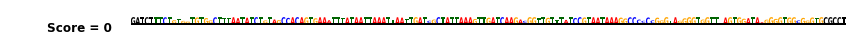

Pattern 1 (PWM & One-hot Sample)


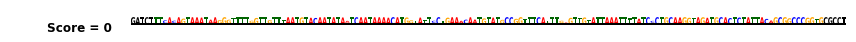

Pattern 2 (PWM & One-hot Sample)


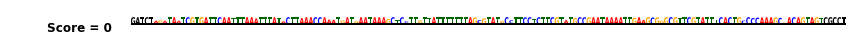

Pattern 3 (PWM & One-hot Sample)


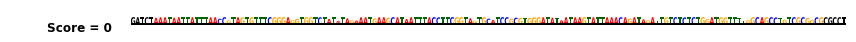

Pattern 4 (PWM & One-hot Sample)


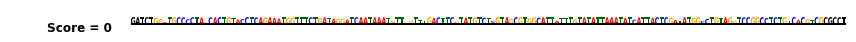

Epoch 2/25
Data index (train) = [66734  1415 74069 ... 69374 77737 37148]
Entropy anneal coeff. = 1.0
5000/5000 [==============================] - 124s 25ms/step
- Generator Train Loss = -0.3799642
- Entropy Train Loss = 0.0063673737
- Discriminator Train Loss (real) = -1.2441695
- Discriminator Train Loss (fake) = 0.58903456
- Discriminator Train Loss (grad) = 0.13641813
Testing for epoch 2:
- Generator Valid Loss = 0.0067321984
- Entropy Valid Loss = 0.0014231964
- Discriminator Valid Loss (real) = -0.17513303
- Discriminator Valid Loss (fake) = 0.037251964
- Discriminator Valid Loss (grad) = 0.12343188
- Discriminator Valid Score (real) = 0.29424107
- Discriminator Valid Score (fake) = 0.022111015
- Discriminator Correct % = 51.01
- Fake Patterns (Randomly Generated) -
Pattern 0 (PWM & One-hot Sample)


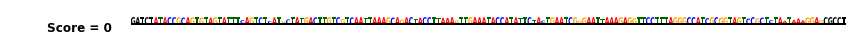

Pattern 1 (PWM & One-hot Sample)


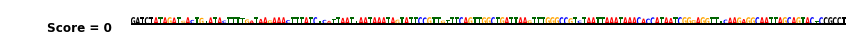

Pattern 2 (PWM & One-hot Sample)


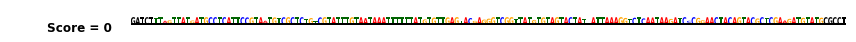

Pattern 3 (PWM & One-hot Sample)


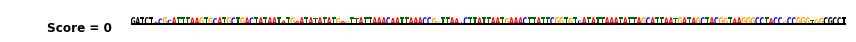

Pattern 4 (PWM & One-hot Sample)


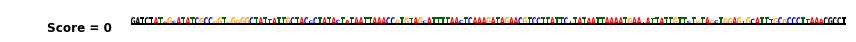

Epoch 3/25
Data index (train) = [73656 42425 11511 ... 22400 32564 66859]
Entropy anneal coeff. = 1.0
5000/5000 [==============================] - 121s 24ms/step
- Generator Train Loss = 0.89774513
- Entropy Train Loss = 0.0016109789
- Discriminator Train Loss (real) = 0.2491315
- Discriminator Train Loss (fake) = -0.74508846
- Discriminator Train Loss (grad) = 0.12200824
Testing for epoch 3:
- Generator Valid Loss = 6.2851505
- Entropy Valid Loss = 0.00065982173
- Discriminator Valid Loss (real) = 5.602572
- Discriminator Valid Loss (fake) = -6.359196
- Discriminator Valid Loss (grad) = 0.12081512
- Discriminator Valid Score (real) = -5.5822287
- Discriminator Valid Score (fake) = -6.310446
- Discriminator Correct % = 54.24
- Fake Patterns (Randomly Generated) -
Pattern 0 (PWM & One-hot Sample)


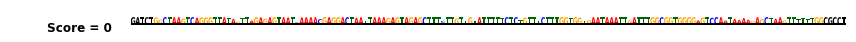

Pattern 1 (PWM & One-hot Sample)


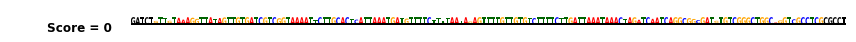

Pattern 2 (PWM & One-hot Sample)


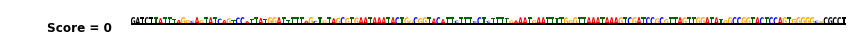

Pattern 3 (PWM & One-hot Sample)


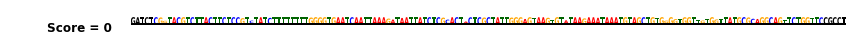

Pattern 4 (PWM & One-hot Sample)


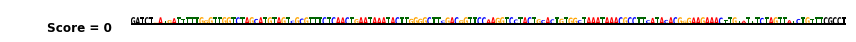

Epoch 4/25
Data index (train) = [47075 20672 18129 ... 64805 18003 21007]
Entropy anneal coeff. = 1.0
5000/5000 [==============================] - 123s 25ms/step
- Generator Train Loss = 0.6251901
- Entropy Train Loss = 0.0009695371
- Discriminator Train Loss (real) = 0.14148378
- Discriminator Train Loss (fake) = -0.46788985
- Discriminator Train Loss (grad) = 0.102629796
Testing for epoch 4:
- Generator Valid Loss = -2.3650289
- Entropy Valid Loss = 0.0012055092
- Discriminator Valid Loss (real) = -2.4230337
- Discriminator Valid Loss (fake) = 2.2481532
- Discriminator Valid Loss (grad) = 0.08188076
- Discriminator Valid Score (real) = 2.4341054
- Discriminator Valid Score (fake) = 2.377631
- Discriminator Correct % = 50.1
- Fake Patterns (Randomly Generated) -
Pattern 0 (PWM & One-hot Sample)


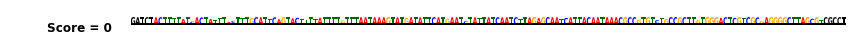

Pattern 1 (PWM & One-hot Sample)


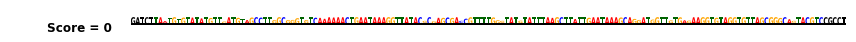

Pattern 2 (PWM & One-hot Sample)


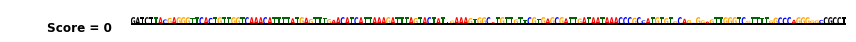

Pattern 3 (PWM & One-hot Sample)


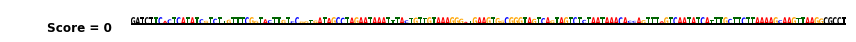

Pattern 4 (PWM & One-hot Sample)


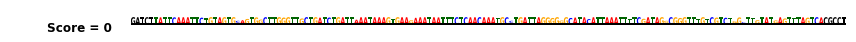

Epoch 5/25
Data index (train) = [76091 66272 73710 ... 37453 17331 75494]
Entropy anneal coeff. = 1.0
5000/5000 [==============================] - 124s 25ms/step
- Generator Train Loss = 2.4862776
- Entropy Train Loss = 0.0010571198
- Discriminator Train Loss (real) = 2.0314128
- Discriminator Train Loss (fake) = -2.3427389
- Discriminator Train Loss (grad) = 0.07657667
Testing for epoch 5:
- Generator Valid Loss = 6.084556
- Entropy Valid Loss = 0.00091048825
- Discriminator Valid Loss (real) = 5.8764133
- Discriminator Valid Loss (fake) = -5.9397006
- Discriminator Valid Loss (grad) = 0.06519429
- Discriminator Valid Score (real) = -5.6595182
- Discriminator Valid Score (fake) = -6.1783195
- Discriminator Correct % = 53.06
- Fake Patterns (Randomly Generated) -
Pattern 0 (PWM & One-hot Sample)


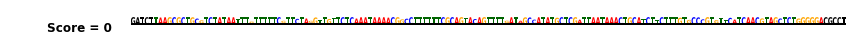

Pattern 1 (PWM & One-hot Sample)


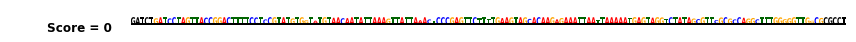

Pattern 2 (PWM & One-hot Sample)


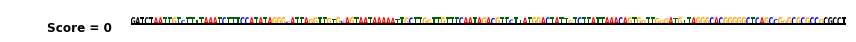

Pattern 3 (PWM & One-hot Sample)


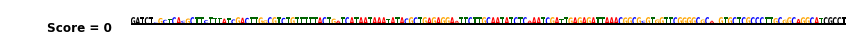

Pattern 4 (PWM & One-hot Sample)


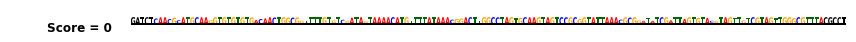

Epoch 6/25
Data index (train) = [18735 82068 35044 ... 26550 56419 78651]
Entropy anneal coeff. = 1.0
5000/5000 [==============================] - 122s 24ms/step
- Generator Train Loss = 0.95043486
- Entropy Train Loss = 0.0008821546
- Discriminator Train Loss (real) = 0.6245115
- Discriminator Train Loss (fake) = -0.88405526
- Discriminator Train Loss (grad) = 0.06416755
Testing for epoch 6:
- Generator Valid Loss = -5.135369
- Entropy Valid Loss = 0.000472239
- Discriminator Valid Loss (real) = -5.84826
- Discriminator Valid Loss (fake) = 5.321898
- Discriminator Valid Loss (grad) = 0.052826412
- Discriminator Valid Score (real) = 5.5667925
- Discriminator Valid Score (fake) = 5.1980634
- Discriminator Correct % = 51.66
- Fake Patterns (Randomly Generated) -
Pattern 0 (PWM & One-hot Sample)


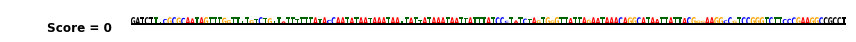

Pattern 1 (PWM & One-hot Sample)


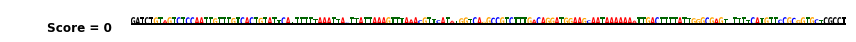

Pattern 2 (PWM & One-hot Sample)


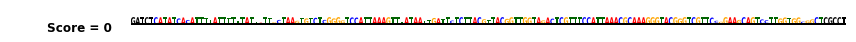

Pattern 3 (PWM & One-hot Sample)


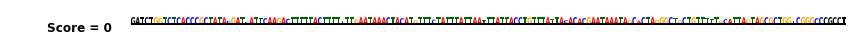

Pattern 4 (PWM & One-hot Sample)


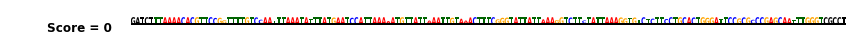

Epoch 7/25
Data index (train) = [66412 71942 24038 ... 10354 85771 27852]
Entropy anneal coeff. = 1.0
5000/5000 [==============================] - 124s 25ms/step
- Generator Train Loss = -3.870307
- Entropy Train Loss = 0.0006325915
- Discriminator Train Loss (real) = -4.0685835
- Discriminator Train Loss (fake) = 3.8589008
- Discriminator Train Loss (grad) = 0.05226708
Testing for epoch 7:
- Generator Valid Loss = -4.4710894
- Entropy Valid Loss = 0.000490384
- Discriminator Valid Loss (real) = -4.750543
- Discriminator Valid Loss (fake) = 4.3901033
- Discriminator Valid Loss (grad) = 0.063476615
- Discriminator Valid Score (real) = 4.8649993
- Discriminator Valid Score (fake) = 4.400492
- Discriminator Correct % = 53.61
- Fake Patterns (Randomly Generated) -
Pattern 0 (PWM & One-hot Sample)


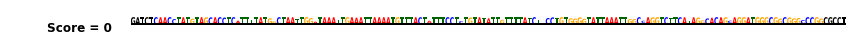

Pattern 1 (PWM & One-hot Sample)


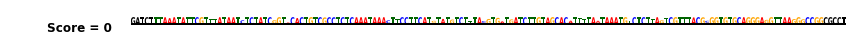

Pattern 2 (PWM & One-hot Sample)


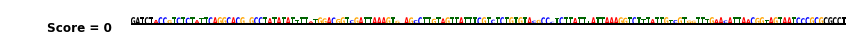

Pattern 3 (PWM & One-hot Sample)


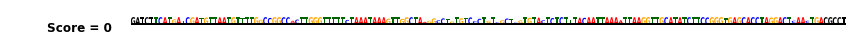

Pattern 4 (PWM & One-hot Sample)


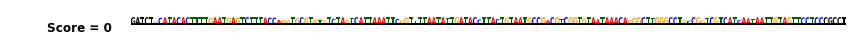

Epoch 8/25
Data index (train) = [62117 14469 72937 ... 16318 16682 29360]
Entropy anneal coeff. = 1.0
5000/5000 [==============================] - 123s 25ms/step
- Generator Train Loss = -2.1790829
- Entropy Train Loss = 0.00030433523
- Discriminator Train Loss (real) = -2.4424362
- Discriminator Train Loss (fake) = 2.263509
- Discriminator Train Loss (grad) = 0.04295877
Testing for epoch 8:
- Generator Valid Loss = 6.907926
- Entropy Valid Loss = 0.00038047694
- Discriminator Valid Loss (real) = 6.7589626
- Discriminator Valid Loss (fake) = -6.8938093
- Discriminator Valid Loss (grad) = 0.05291584
- Discriminator Valid Score (real) = -6.558109
- Discriminator Valid Score (fake) = -7.026056
- Discriminator Correct % = 52.45
- Fake Patterns (Randomly Generated) -
Pattern 0 (PWM & One-hot Sample)


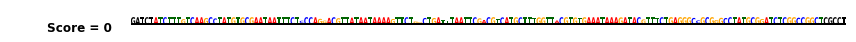

Pattern 1 (PWM & One-hot Sample)


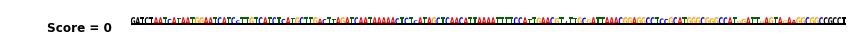

Pattern 2 (PWM & One-hot Sample)


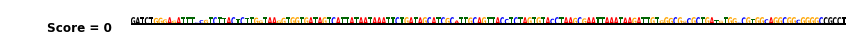

Pattern 3 (PWM & One-hot Sample)


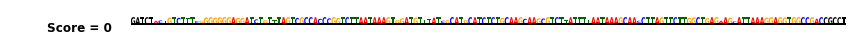

Pattern 4 (PWM & One-hot Sample)


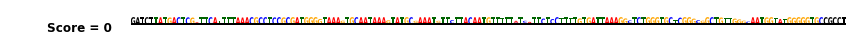

Epoch 9/25
Data index (train) = [46256 33876 60367 ... 12242 42778 68513]
Entropy anneal coeff. = 1.0
5000/5000 [==============================] - 124s 25ms/step
- Generator Train Loss = 0.41578767
- Entropy Train Loss = 0.0003126147
- Discriminator Train Loss (real) = 0.1906115
- Discriminator Train Loss (fake) = -0.37317327
- Discriminator Train Loss (grad) = 0.03853335
Testing for epoch 9:
- Generator Valid Loss = -9.172311
- Entropy Valid Loss = 0.00014699606
- Discriminator Valid Loss (real) = -9.097499
- Discriminator Valid Loss (fake) = 8.925678
- Discriminator Valid Loss (grad) = 0.049093995
- Discriminator Valid Score (real) = 8.845995
- Discriminator Valid Score (fake) = 9.060722
- Discriminator Correct % = 50.46
- Fake Patterns (Randomly Generated) -
Pattern 0 (PWM & One-hot Sample)


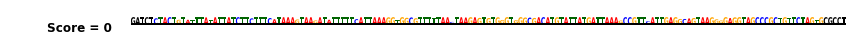

Pattern 1 (PWM & One-hot Sample)


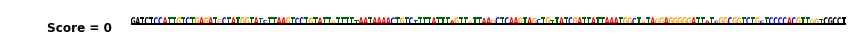

Pattern 2 (PWM & One-hot Sample)


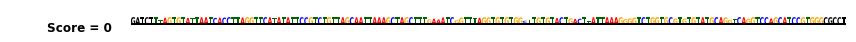

Pattern 3 (PWM & One-hot Sample)


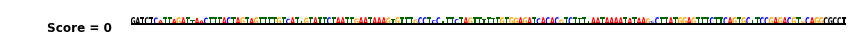

Pattern 4 (PWM & One-hot Sample)


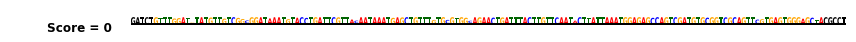

Epoch 10/25
Data index (train) = [39734 20830 57213 ... 65998 69869  6117]
Entropy anneal coeff. = 1.0
5000/5000 [==============================] - 124s 25ms/step
- Generator Train Loss = -0.18919815
- Entropy Train Loss = 0.00017375725
- Discriminator Train Loss (real) = -0.38914156
- Discriminator Train Loss (fake) = 0.21530049
- Discriminator Train Loss (grad) = 0.03811738
Testing for epoch 10:
- Generator Valid Loss = -2.8351898
- Entropy Valid Loss = 8.09283e-06
- Discriminator Valid Loss (real) = -2.9072254
- Discriminator Valid Loss (fake) = 3.1169882
- Discriminator Valid Loss (grad) = 0.025499195
- Discriminator Valid Score (real) = 3.0535083
- Discriminator Valid Score (fake) = 3.1948824
- Discriminator Correct % = 49.62
- Fake Patterns (Randomly Generated) -
Pattern 0 (PWM & One-hot Sample)


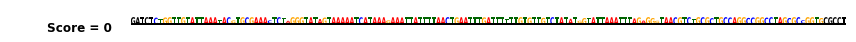

Pattern 1 (PWM & One-hot Sample)


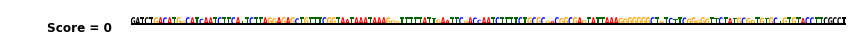

Pattern 2 (PWM & One-hot Sample)


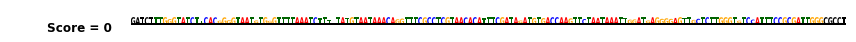

Pattern 3 (PWM & One-hot Sample)


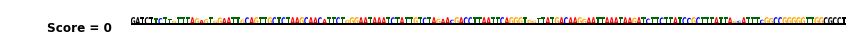

Pattern 4 (PWM & One-hot Sample)


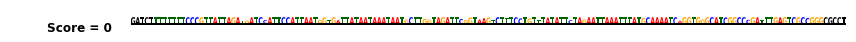

Epoch 11/25
Data index (train) = [21991 18959 21433 ... 21480 57972 43736]
Entropy anneal coeff. = 1.0
5000/5000 [==============================] - 121s 24ms/step
- Generator Train Loss = -12.132586
- Entropy Train Loss = 3.0469939e-05
- Discriminator Train Loss (real) = -12.461544
- Discriminator Train Loss (fake) = 12.240732
- Discriminator Train Loss (grad) = 0.03737583
Testing for epoch 11:
- Generator Valid Loss = -17.410755
- Entropy Valid Loss = 4.097359e-05
- Discriminator Valid Loss (real) = -16.854889
- Discriminator Valid Loss (fake) = 16.734764
- Discriminator Valid Loss (grad) = 0.031540632
- Discriminator Valid Score (real) = 16.640488
- Discriminator Valid Score (fake) = 16.890665
- Discriminator Correct % = 49.69
- Fake Patterns (Randomly Generated) -
Pattern 0 (PWM & One-hot Sample)


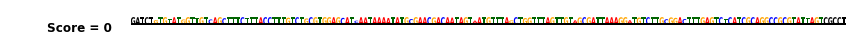

Pattern 1 (PWM & One-hot Sample)


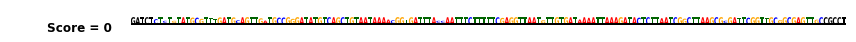

Pattern 2 (PWM & One-hot Sample)


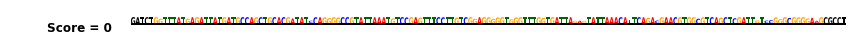

Pattern 3 (PWM & One-hot Sample)


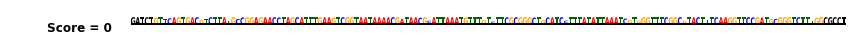

Pattern 4 (PWM & One-hot Sample)


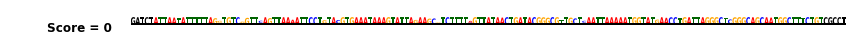

Epoch 12/25
Data index (train) = [13466 40198 37205 ... 55474 38747 80896]
Entropy anneal coeff. = 1.0
5000/5000 [==============================] - 124s 25ms/step
- Generator Train Loss = -18.685583
- Entropy Train Loss = 2.3926243e-05
- Discriminator Train Loss (real) = -18.71029
- Discriminator Train Loss (fake) = 18.409737
- Discriminator Train Loss (grad) = 0.045547936
Testing for epoch 12:
- Generator Valid Loss = -26.877836
- Entropy Valid Loss = 0.0
- Discriminator Valid Loss (real) = -27.295671
- Discriminator Valid Loss (fake) = 27.877264
- Discriminator Valid Loss (grad) = 0.035989545
- Discriminator Valid Score (real) = 27.360378
- Discriminator Valid Score (fake) = 27.085793
- Discriminator Correct % = 49.41
- Fake Patterns (Randomly Generated) -
Pattern 0 (PWM & One-hot Sample)


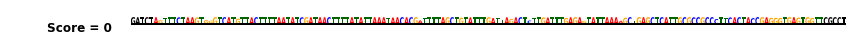

Pattern 1 (PWM & One-hot Sample)


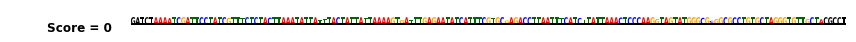

Pattern 2 (PWM & One-hot Sample)


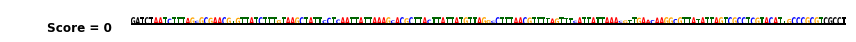

Pattern 3 (PWM & One-hot Sample)


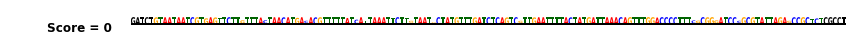

Pattern 4 (PWM & One-hot Sample)


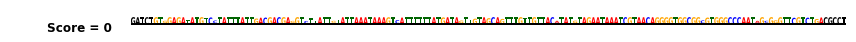

Epoch 13/25
Data index (train) = [74221 26188  6475 ...  5660 72030   265]
Entropy anneal coeff. = 1.0
5000/5000 [==============================] - 124s 25ms/step
- Generator Train Loss = -12.8685055
- Entropy Train Loss = 1.3911069e-05
- Discriminator Train Loss (real) = -12.995457
- Discriminator Train Loss (fake) = 12.889641
- Discriminator Train Loss (grad) = 0.036174748
Testing for epoch 13:
- Generator Valid Loss = -18.5716
- Entropy Valid Loss = 3.4146862e-05
- Discriminator Valid Loss (real) = -17.631887
- Discriminator Valid Loss (fake) = 17.88531
- Discriminator Valid Loss (grad) = 0.032214202
- Discriminator Valid Score (real) = 18.44493
- Discriminator Valid Score (fake) = 17.75059
- Discriminator Correct % = 50.44
- Fake Patterns (Randomly Generated) -
Pattern 0 (PWM & One-hot Sample)


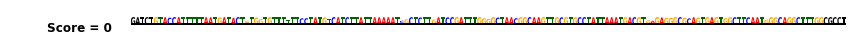

Pattern 1 (PWM & One-hot Sample)


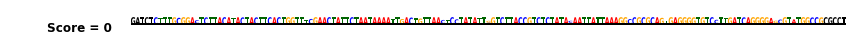

Pattern 2 (PWM & One-hot Sample)


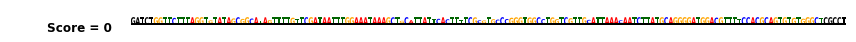

Pattern 3 (PWM & One-hot Sample)


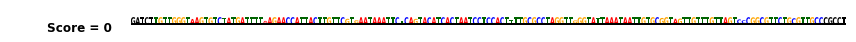

Pattern 4 (PWM & One-hot Sample)


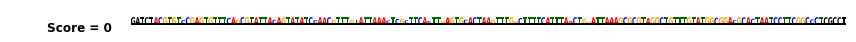

Epoch 14/25
Data index (train) = [ 4896 16582 16316 ... 77489 44903 65078]
Entropy anneal coeff. = 1.0
5000/5000 [==============================] - 122s 24ms/step
- Generator Train Loss = 5.419903
- Entropy Train Loss = 6.416672e-05
- Discriminator Train Loss (real) = 5.2657466
- Discriminator Train Loss (fake) = -5.312644
- Discriminator Train Loss (grad) = 0.035831116
Testing for epoch 14:
- Generator Valid Loss = 11.499098
- Entropy Valid Loss = 2.3963867e-05
- Discriminator Valid Loss (real) = 11.626276
- Discriminator Valid Loss (fake) = -11.868639
- Discriminator Valid Loss (grad) = 0.037968412
- Discriminator Valid Score (real) = -11.572437
- Discriminator Valid Score (fake) = -11.717125
- Discriminator Correct % = 50.52
- Fake Patterns (Randomly Generated) -
Pattern 0 (PWM & One-hot Sample)


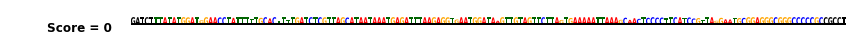

Pattern 1 (PWM & One-hot Sample)


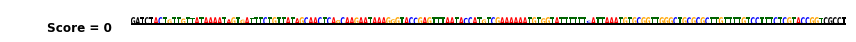

Pattern 2 (PWM & One-hot Sample)


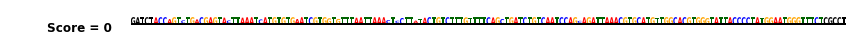

Pattern 3 (PWM & One-hot Sample)


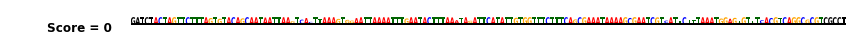

Pattern 4 (PWM & One-hot Sample)


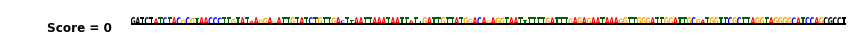

Epoch 15/25
Data index (train) = [41958 59323 31947 ... 20453  3398 65873]
Entropy anneal coeff. = 1.0
5000/5000 [==============================] - 124s 25ms/step
- Generator Train Loss = 3.9808433
- Entropy Train Loss = 6.292085e-05
- Discriminator Train Loss (real) = 3.525858
- Discriminator Train Loss (fake) = -3.7258997
- Discriminator Train Loss (grad) = 0.03148785
Testing for epoch 15:
- Generator Valid Loss = -1.0820116
- Entropy Valid Loss = 3.9213054e-07
- Discriminator Valid Loss (real) = -0.8855702
- Discriminator Valid Loss (fake) = -0.14395583
- Discriminator Valid Loss (grad) = 0.06018479
- Discriminator Valid Score (real) = 1.6933796
- Discriminator Valid Score (fake) = 1.6565343
- Discriminator Correct % = 50.23
- Fake Patterns (Randomly Generated) -
Pattern 0 (PWM & One-hot Sample)


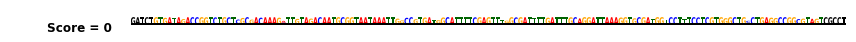

Pattern 1 (PWM & One-hot Sample)


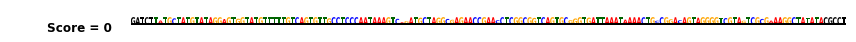

Pattern 2 (PWM & One-hot Sample)


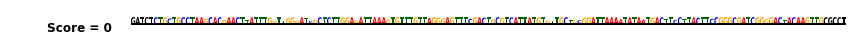

Pattern 3 (PWM & One-hot Sample)


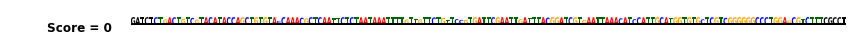

Pattern 4 (PWM & One-hot Sample)


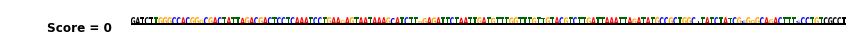

Epoch 16/25
Data index (train) = [15692 55217 62087 ... 39305 79275  2087]
Entropy anneal coeff. = 1.0
5000/5000 [==============================] - 124s 25ms/step
- Generator Train Loss = 0.46876952
- Entropy Train Loss = 4.0322735e-05
- Discriminator Train Loss (real) = 0.06004795
- Discriminator Train Loss (fake) = -0.056428615
- Discriminator Train Loss (grad) = 0.032656178
Testing for epoch 16:
- Generator Valid Loss = -1.9658911
- Entropy Valid Loss = 2.298479e-06
- Discriminator Valid Loss (real) = -2.3282728
- Discriminator Valid Loss (fake) = 2.1276946
- Discriminator Valid Loss (grad) = 0.03986314
- Discriminator Valid Score (real) = 2.2566433
- Discriminator Valid Score (fake) = 2.5691404
- Discriminator Correct % = 49.2
- Fake Patterns (Randomly Generated) -
Pattern 0 (PWM & One-hot Sample)


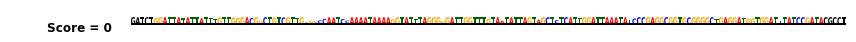

Pattern 1 (PWM & One-hot Sample)


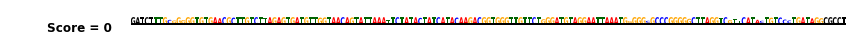

Pattern 2 (PWM & One-hot Sample)


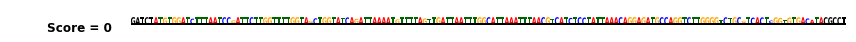

Pattern 3 (PWM & One-hot Sample)


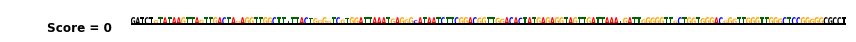

Pattern 4 (PWM & One-hot Sample)


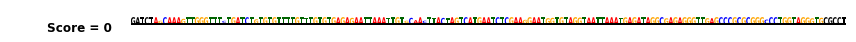

Epoch 17/25
Data index (train) = [79276  3013 17864 ... 65130 54986 70409]
Entropy anneal coeff. = 1.0
5000/5000 [==============================] - 122s 24ms/step
- Generator Train Loss = 13.081916
- Entropy Train Loss = 5.86465e-06
- Discriminator Train Loss (real) = 13.098924
- Discriminator Train Loss (fake) = -13.3200655
- Discriminator Train Loss (grad) = 0.02827685
Testing for epoch 17:
- Generator Valid Loss = 12.19419
- Entropy Valid Loss = 0.0
- Discriminator Valid Loss (real) = 13.077623
- Discriminator Valid Loss (fake) = -12.090873
- Discriminator Valid Loss (grad) = 0.03398054
- Discriminator Valid Score (real) = -11.340178
- Discriminator Valid Score (fake) = -12.246164
- Discriminator Correct % = 50.86
- Fake Patterns (Randomly Generated) -
Pattern 0 (PWM & One-hot Sample)


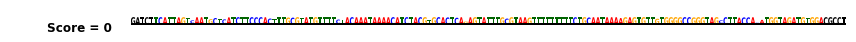

Pattern 1 (PWM & One-hot Sample)


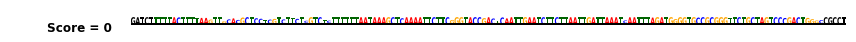

Pattern 2 (PWM & One-hot Sample)


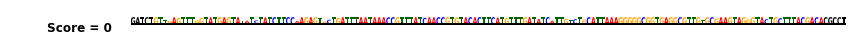

Pattern 3 (PWM & One-hot Sample)


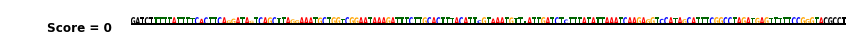

Pattern 4 (PWM & One-hot Sample)


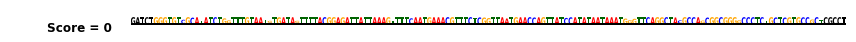

Epoch 18/25
Data index (train) = [57231 41917 84406 ... 39671 13045  1929]
Entropy anneal coeff. = 1.0
5000/5000 [==============================] - 125s 25ms/step
- Generator Train Loss = -5.728211
- Entropy Train Loss = 3.22181e-06
- Discriminator Train Loss (real) = -5.7780576
- Discriminator Train Loss (fake) = 5.8485866
- Discriminator Train Loss (grad) = 0.032132115
Testing for epoch 18:
- Generator Valid Loss = -1.9962412
- Entropy Valid Loss = 0.0
- Discriminator Valid Loss (real) = -2.153994
- Discriminator Valid Loss (fake) = 2.1646438
- Discriminator Valid Loss (grad) = 0.033792805
- Discriminator Valid Score (real) = 2.4201102
- Discriminator Valid Score (fake) = 2.1072617
- Discriminator Correct % = 51.55
- Fake Patterns (Randomly Generated) -
Pattern 0 (PWM & One-hot Sample)


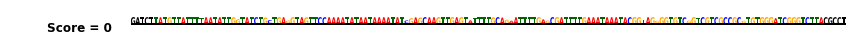

Pattern 1 (PWM & One-hot Sample)


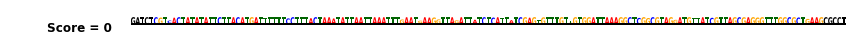

Pattern 2 (PWM & One-hot Sample)


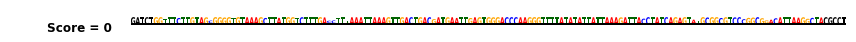

Pattern 3 (PWM & One-hot Sample)


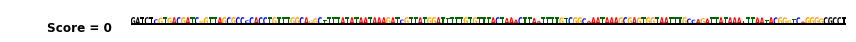

Pattern 4 (PWM & One-hot Sample)


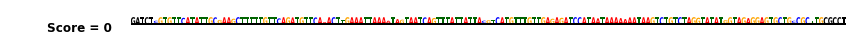

Epoch 19/25
Data index (train) = [ 4494 73117 82999 ... 27101 81685  8882]
Entropy anneal coeff. = 1.0
5000/5000 [==============================] - 123s 25ms/step
- Generator Train Loss = -16.187786
- Entropy Train Loss = 0.0
- Discriminator Train Loss (real) = -16.048607
- Discriminator Train Loss (fake) = 15.755766
- Discriminator Train Loss (grad) = 0.031738482
Testing for epoch 19:
- Generator Valid Loss = -48.20307
- Entropy Valid Loss = 0.0
- Discriminator Valid Loss (real) = -46.273613
- Discriminator Valid Loss (fake) = 48.330963
- Discriminator Valid Loss (grad) = 0.05635847
- Discriminator Valid Score (real) = 47.278385
- Discriminator Valid Score (fake) = 45.519417
- Discriminator Correct % = 50.5
- Fake Patterns (Randomly Generated) -
Pattern 0 (PWM & One-hot Sample)


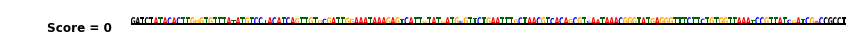

Pattern 1 (PWM & One-hot Sample)


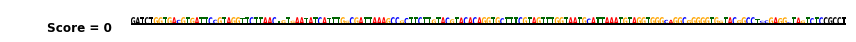

Pattern 2 (PWM & One-hot Sample)


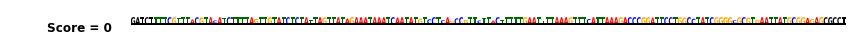

Pattern 3 (PWM & One-hot Sample)


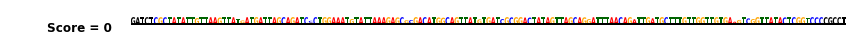

Pattern 4 (PWM & One-hot Sample)


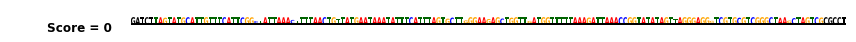

Epoch 20/25
Data index (train) = [36705 51875 53495 ...  4458 13049 75794]
Entropy anneal coeff. = 1.0
5000/5000 [==============================] - 121s 24ms/step
- Generator Train Loss = -22.859222
- Entropy Train Loss = 1.5669226e-05
- Discriminator Train Loss (real) = -22.944162
- Discriminator Train Loss (fake) = 22.967052
- Discriminator Train Loss (grad) = 0.036106274
Testing for epoch 20:
- Generator Valid Loss = 0.57826567
- Entropy Valid Loss = 0.0
- Discriminator Valid Loss (real) = 0.3594148
- Discriminator Valid Loss (fake) = -0.6101826
- Discriminator Valid Loss (grad) = 0.037149854
- Discriminator Valid Score (real) = -0.14577344
- Discriminator Valid Score (fake) = -0.4932294
- Discriminator Correct % = 50.31
- Fake Patterns (Randomly Generated) -
Pattern 0 (PWM & One-hot Sample)


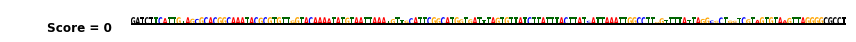

Pattern 1 (PWM & One-hot Sample)


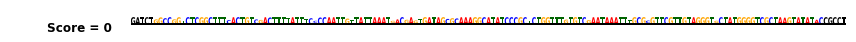

Pattern 2 (PWM & One-hot Sample)


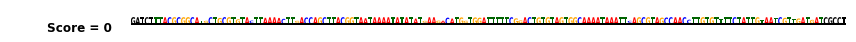

Pattern 3 (PWM & One-hot Sample)


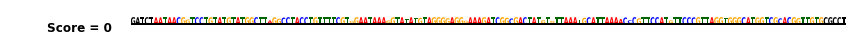

Pattern 4 (PWM & One-hot Sample)


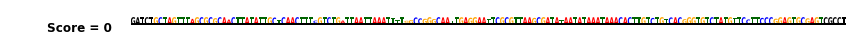

Epoch 21/25
Data index (train) = [28995 52937 83261 ... 80896 78356 60654]
Entropy anneal coeff. = 1.0
5000/5000 [==============================] - 124s 25ms/step
- Generator Train Loss = 7.7238584
- Entropy Train Loss = 5.0158055e-06
- Discriminator Train Loss (real) = 7.6884813
- Discriminator Train Loss (fake) = -7.8564553
- Discriminator Train Loss (grad) = 0.0289677
Testing for epoch 21:
- Generator Valid Loss = 10.823814
- Entropy Valid Loss = 1.6386277e-06
- Discriminator Valid Loss (real) = 11.102092
- Discriminator Valid Loss (fake) = -11.22938
- Discriminator Valid Loss (grad) = 0.02435983
- Discriminator Valid Score (real) = -11.493774
- Discriminator Valid Score (fake) = -12.036304
- Discriminator Correct % = 50.9
- Fake Patterns (Randomly Generated) -
Pattern 0 (PWM & One-hot Sample)


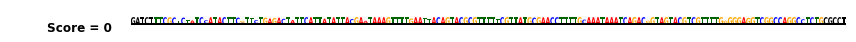

Pattern 1 (PWM & One-hot Sample)


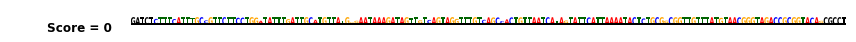

Pattern 2 (PWM & One-hot Sample)


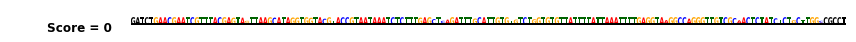

Pattern 3 (PWM & One-hot Sample)


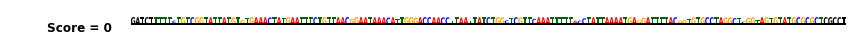

Pattern 4 (PWM & One-hot Sample)


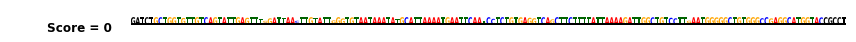

Epoch 22/25
Data index (train) = [71238 56255  6961 ... 28834 50877 83640]
Entropy anneal coeff. = 1.0
5000/5000 [==============================] - 124s 25ms/step
- Generator Train Loss = 16.91841
- Entropy Train Loss = 0.0
- Discriminator Train Loss (real) = 16.85631
- Discriminator Train Loss (fake) = -17.09449
- Discriminator Train Loss (grad) = 0.03364437
Testing for epoch 22:
- Generator Valid Loss = 32.369183
- Entropy Valid Loss = 5.3821195e-06
- Discriminator Valid Loss (real) = 33.355885
- Discriminator Valid Loss (fake) = -33.92045
- Discriminator Valid Loss (grad) = 0.021236122
- Discriminator Valid Score (real) = -33.64068
- Discriminator Valid Score (fake) = -33.03554
- Discriminator Correct % = 49.41
- Fake Patterns (Randomly Generated) -
Pattern 0 (PWM & One-hot Sample)


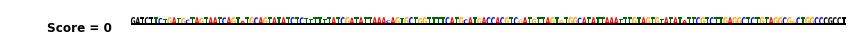

Pattern 1 (PWM & One-hot Sample)


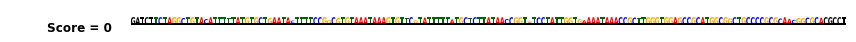

Pattern 2 (PWM & One-hot Sample)


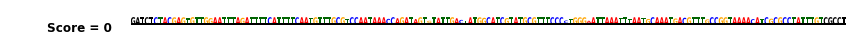

Pattern 3 (PWM & One-hot Sample)


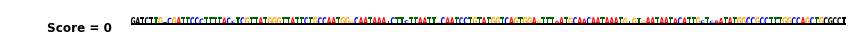

Pattern 4 (PWM & One-hot Sample)


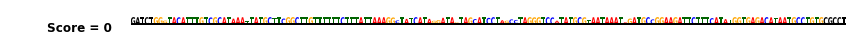

Epoch 23/25
Data index (train) = [41330  7078 57546 ...  3844 61051 17896]
Entropy anneal coeff. = 1.0
5000/5000 [==============================] - 122s 24ms/step
- Generator Train Loss = 30.759825
- Entropy Train Loss = 2.5289655e-06
- Discriminator Train Loss (real) = 30.895084
- Discriminator Train Loss (fake) = -30.809196
- Discriminator Train Loss (grad) = 0.031104526
Testing for epoch 23:
- Generator Valid Loss = 19.912731
- Entropy Valid Loss = 0.0
- Discriminator Valid Loss (real) = 19.762407
- Discriminator Valid Loss (fake) = -20.05404
- Discriminator Valid Loss (grad) = 0.018691558
- Discriminator Valid Score (real) = -19.804054
- Discriminator Valid Score (fake) = -19.985325
- Discriminator Correct % = 50.13
- Fake Patterns (Randomly Generated) -
Pattern 0 (PWM & One-hot Sample)


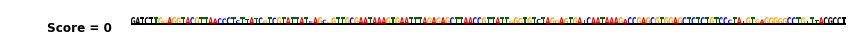

Pattern 1 (PWM & One-hot Sample)


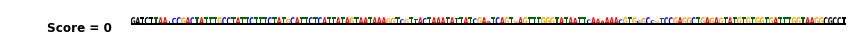

Pattern 2 (PWM & One-hot Sample)


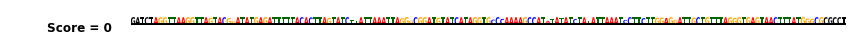

Pattern 3 (PWM & One-hot Sample)


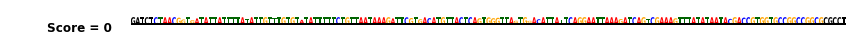

Pattern 4 (PWM & One-hot Sample)


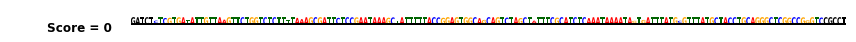

Epoch 24/25
Data index (train) = [40274 18710 67281 ... 11090 49020 10803]
Entropy anneal coeff. = 1.0
5000/5000 [==============================] - 123s 25ms/step
- Generator Train Loss = 6.5743294
- Entropy Train Loss = 1.7419458e-06
- Discriminator Train Loss (real) = 6.6108365
- Discriminator Train Loss (fake) = -6.761664
- Discriminator Train Loss (grad) = 0.026340924
Testing for epoch 24:
- Generator Valid Loss = 7.349802
- Entropy Valid Loss = 0.0
- Discriminator Valid Loss (real) = 7.615916
- Discriminator Valid Loss (fake) = -7.515076
- Discriminator Valid Loss (grad) = 0.020723864
- Discriminator Valid Score (real) = -7.3673496
- Discriminator Valid Score (fake) = -7.2979007
- Discriminator Correct % = 49.75
- Fake Patterns (Randomly Generated) -
Pattern 0 (PWM & One-hot Sample)


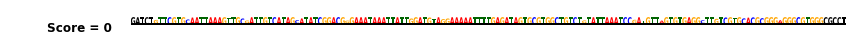

Pattern 1 (PWM & One-hot Sample)


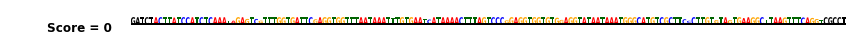

Pattern 2 (PWM & One-hot Sample)


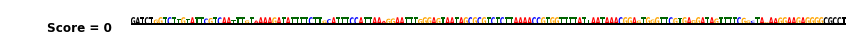

Pattern 3 (PWM & One-hot Sample)


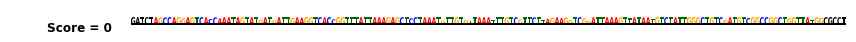

Pattern 4 (PWM & One-hot Sample)


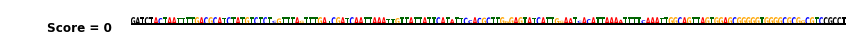

Epoch 25/25
Data index (train) = [ 4044  9188  5343 ... 41655 71978  3610]
Entropy anneal coeff. = 1.0
5000/5000 [==============================] - 123s 25ms/step
- Generator Train Loss = 33.760086
- Entropy Train Loss = 2.0654827e-05
- Discriminator Train Loss (real) = 33.506336
- Discriminator Train Loss (fake) = -33.82971
- Discriminator Train Loss (grad) = 0.02806522
Testing for epoch 25:
- Generator Valid Loss = 53.217926
- Entropy Valid Loss = 0.0
- Discriminator Valid Loss (real) = 52.36821
- Discriminator Valid Loss (fake) = -52.173595
- Discriminator Valid Loss (grad) = 0.026338123
- Discriminator Valid Score (real) = -53.03593
- Discriminator Valid Score (fake) = -53.575058
- Discriminator Correct % = 50.1
- Fake Patterns (Randomly Generated) -
Pattern 0 (PWM & One-hot Sample)


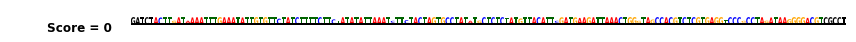

Pattern 1 (PWM & One-hot Sample)


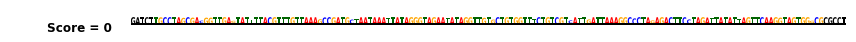

Pattern 2 (PWM & One-hot Sample)


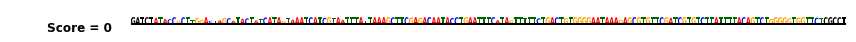

Pattern 3 (PWM & One-hot Sample)


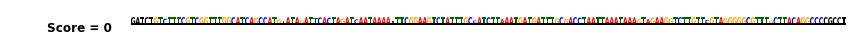

Pattern 4 (PWM & One-hot Sample)


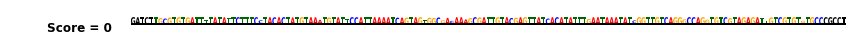

In [19]:

from_epoch = 1

n_epochs = 25

n_iters = 5000

validation_frequency = 1000

training_ratio = 5

verbose = True
verbose_n_pwms, verbose_n_samples = 5, 0

#Specify entropy anneal function
entropy_anneal_func = lambda epoch: 1.0

max_n_valid_batches = 200

epoch_train_history = defaultdict(list)
epoch_valid_history = defaultdict(list)
valid_history = defaultdict(list)

for epoch in range(from_epoch, n_epochs + 1) :
    print('Epoch {}/{}'.format(epoch, n_epochs))
    print("Data index (train) = " + str(data_gens['train'].indexes))

    progress_bar = Progbar(target=n_iters)

    K.set_value(entropy_anneal_coeff, entropy_anneal_func(epoch - 1))
    
    print("Entropy anneal coeff. = " + str(round(K.get_value(entropy_anneal_coeff), 3)))
    
    gen_train_losses = []
    ent_train_losses = []
    
    disc_real_train_losses = []
    disc_fake_train_losses = []
    disc_gp_train_losses = []
    
    for index in range(1, n_iters + 1) :
        sequence_batch = data_gens['train'][(index - 1) % len(data_gens['train'])][0][0]
        
        class_batch = np.zeros((batch_size, 1), dtype=np.int)
        seed_batch = np.random.normal(loc=0., scale=1., size=(batch_size, 100))
        
        _, real_l, fake_l, gp_l = discriminator_model_real_data.train_on_batch(
            [class_batch, seed_batch, sequence_batch],
            [dummy_data_target, dummy_data_target, dummy_data_target]
        )
        
        disc_real_train_losses.append(real_l)
        disc_fake_train_losses.append(fake_l)
        disc_gp_train_losses.append(gp_l)
        
        if index % training_ratio == 0 :
            
            class_batch = np.zeros((batch_size, 1), dtype=np.int)
            seed_batch = np.random.normal(loc=0., scale=1., size=(batch_size, 100))
            
            _, gen_l, ent_l = discriminator_model_fake_data.train_on_batch(
                [class_batch, seed_batch],
                [dummy_data_target, dummy_data_target]
            )
            
            gen_train_losses.append(gen_l)
            ent_train_losses.append(ent_l)
        
        if index % validation_frequency == 0 :
            evaluate_gan(data_gens['valid'], generator_model, discriminator_model, valid_history, batch_size=batch_size, max_n_valid_batches=max_n_valid_batches)
        
        progress_bar.update(index)
    
    gen_train_loss = np.mean(np.array(gen_train_losses), axis=0)
    ent_train_loss = np.mean(np.array(ent_train_losses), axis=0)
    
    disc_real_train_loss = np.mean(np.array(disc_real_train_losses), axis=0)
    disc_fake_train_loss = np.mean(np.array(disc_fake_train_losses), axis=0)
    disc_gp_train_loss = np.mean(np.array(disc_gp_train_losses), axis=0)
    
    epoch_train_history['generator_loss'].append(gen_train_loss)
    epoch_train_history['entropy_loss'].append(ent_train_loss)
    epoch_train_history['discriminator_real_loss'].append(disc_real_train_loss)
    epoch_train_history['discriminator_fake_loss'].append(disc_fake_train_loss)
    epoch_train_history['discriminator_gp_loss'].append(disc_gp_train_loss)
    
    print("- Generator Train Loss = " + str(gen_train_loss))
    print("- Entropy Train Loss = " + str(ent_train_loss))
    print("- Discriminator Train Loss (real) = " + str(disc_real_train_loss))
    print("- Discriminator Train Loss (fake) = " + str(disc_fake_train_loss))
    print("- Discriminator Train Loss (grad) = " + str(disc_gp_train_loss))
    
    
    print('Testing for epoch {}:'.format(epoch))
    
    evaluate_gan_loss(data_gens['valid'], discriminator_model_fake_data, discriminator_model_real_data, epoch_valid_history, batch_size=batch_size, max_n_valid_batches=max_n_valid_batches)
    
    print("- Generator Valid Loss = " + str(epoch_valid_history['generator_loss'][-1]))
    print("- Entropy Valid Loss = " + str(epoch_valid_history['entropy_loss'][-1]))
    print("- Discriminator Valid Loss (real) = " + str(epoch_valid_history['discriminator_real_loss'][-1]))
    print("- Discriminator Valid Loss (fake) = " + str(epoch_valid_history['discriminator_fake_loss'][-1]))
    print("- Discriminator Valid Loss (grad) = " + str(epoch_valid_history['discriminator_gp_loss'][-1]))
    
    evaluate_gan(data_gens['valid'], generator_model, discriminator_model, epoch_valid_history, batch_size=batch_size, max_n_valid_batches=max_n_valid_batches)
    
    print("- Discriminator Valid Score (real) = " + str(epoch_valid_history['discriminator_real_score'][-1]))
    print("- Discriminator Valid Score (fake) = " + str(epoch_valid_history['discriminator_fake_score'][-1]))
    print("- Discriminator Correct % = " + str(round(epoch_valid_history['discriminator_accuracy'][-1] * 100, 2)))

    if verbose :
    
        print("- Fake Patterns (Randomly Generated) -")
        
        class_batch = np.zeros((batch_size, 1), dtype=np.int)
        seed_batch = np.random.normal(loc=0., scale=1., size=(batch_size, 100))
        
        _, fake_pwm_batch, fake_sequence_batch = generator_model.predict_on_batch(x=[class_batch, seed_batch])

        for plot_i in range(min(verbose_n_pwms, batch_size)) :
            print('Pattern ' + str(plot_i) + ' (PWM & One-hot Sample)')
            plot_gan_logo(fake_pwm_batch[plot_i, 0, :, :], 0, sequence_template=sequence_templates[0], figsize=(12, 0.5), width_ratios=[1, 7], logo_height=1.0, plot_start=20, plot_end=177)
            
    data_gens['train'].on_epoch_end()


--- Training Losses ---

(Generator Losses)


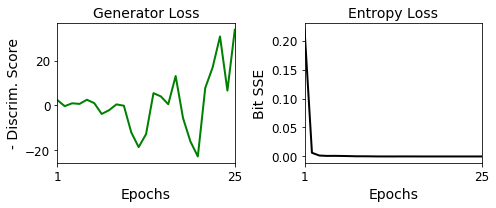

(Discriminator Losses)


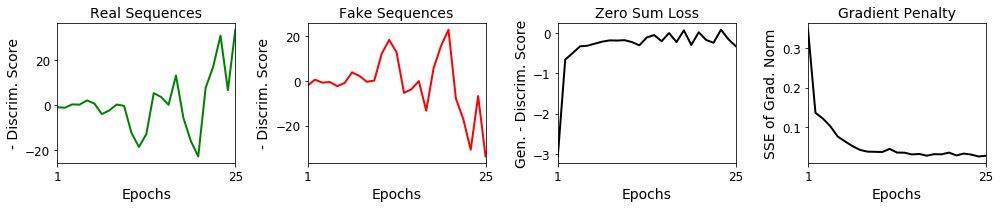

--- Validation Losses ---

(Generator Losses)


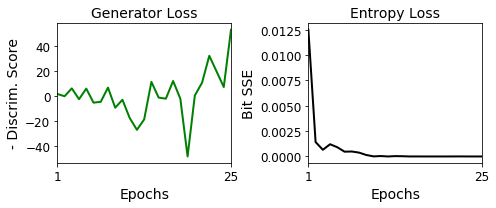

(Discriminator Losses)


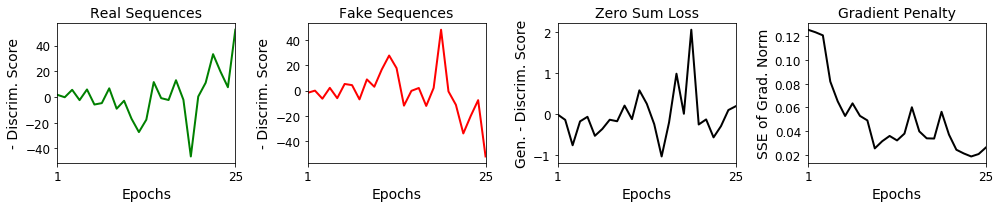

In [20]:

for eval_str, eval_history in [('Training', epoch_train_history), ('Validation', epoch_valid_history)] :

    print("--- " + eval_str + " Losses ---")
    print("")
    
    print("(Generator Losses)")
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(3.5 * 2, 3))

    ax1.plot(np.arange(1, n_epochs + 1), eval_history['generator_loss'], linewidth=2, color='green')

    plt.sca(ax1)
    plt.xlabel("Epochs", fontsize=14)
    plt.ylabel("- Discrim. Score", fontsize=14)
    plt.title("Generator Loss", fontsize=14)
    plt.xlim(1, n_epochs)
    plt.xticks([1, n_epochs], [1, n_epochs], fontsize=12)
    plt.yticks(fontsize=12)

    ax2.plot(np.arange(1, n_epochs + 1), eval_history['entropy_loss'], linewidth=2, color='black')

    plt.sca(ax2)
    plt.xlabel("Epochs", fontsize=14)
    plt.ylabel("Bit SSE", fontsize=14)
    plt.title("Entropy Loss", fontsize=14)
    plt.xlim(1, n_epochs)
    plt.xticks([1, n_epochs], [1, n_epochs], fontsize=12)
    plt.yticks(fontsize=12)

    plt.tight_layout()

    plt.show()
    
    print("(Discriminator Losses)")

    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(3.5 * 4, 3))

    ax1.plot(np.arange(1, n_epochs + 1), eval_history['discriminator_real_loss'], linewidth=2, color='green')

    plt.sca(ax1)
    plt.xlabel("Epochs", fontsize=14)
    plt.ylabel("- Discrim. Score", fontsize=14)
    plt.title("Real Sequences", fontsize=14)
    plt.xlim(1, n_epochs)
    plt.xticks([1, n_epochs], [1, n_epochs], fontsize=12)
    plt.yticks(fontsize=12)

    ax2.plot(np.arange(1, n_epochs + 1), eval_history['discriminator_fake_loss'], linewidth=2, color='red')

    plt.sca(ax2)
    plt.xlabel("Epochs", fontsize=14)
    plt.ylabel("- Discrim. Score", fontsize=14)
    plt.title("Fake Sequences", fontsize=14)
    plt.xlim(1, n_epochs)
    plt.xticks([1, n_epochs], [1, n_epochs], fontsize=12)
    plt.yticks(fontsize=12)

    ax3.plot(np.arange(1, n_epochs + 1), np.ravel(eval_history['discriminator_fake_loss']) + np.ravel(eval_history['discriminator_real_loss']), linewidth=2, color='black')

    plt.sca(ax3)
    plt.xlabel("Epochs", fontsize=14)
    plt.ylabel("Gen. - Discrim. Score", fontsize=14)
    plt.title("Zero Sum Loss", fontsize=14)
    plt.xlim(1, n_epochs)
    plt.xticks([1, n_epochs], [1, n_epochs], fontsize=12)
    plt.yticks(fontsize=12)
    
    ax4.plot(np.arange(1, n_epochs + 1), eval_history['discriminator_gp_loss'], linewidth=2, color='black')

    plt.sca(ax4)
    plt.xlabel("Epochs", fontsize=14)
    plt.ylabel("SSE of Grad. Norm", fontsize=14)
    plt.title("Gradient Penalty", fontsize=14)
    plt.xlim(1, n_epochs)
    plt.xticks([1, n_epochs], [1, n_epochs], fontsize=12)
    plt.yticks(fontsize=12)

    plt.tight_layout()

    plt.show()


Validation Metrics (Frequent)


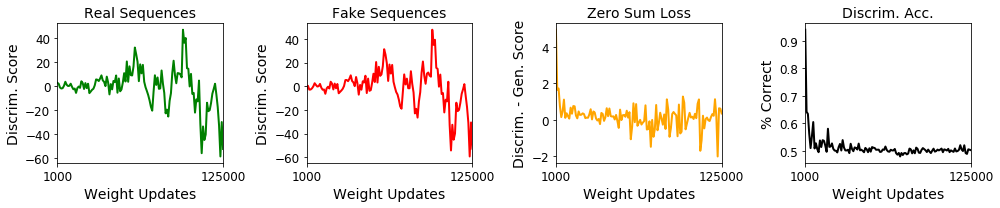

In [21]:
print("Validation Metrics (Frequent)")

f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(3.5 * 4, 3))

t = np.arange(1, len(valid_history['discriminator_real_score']) + 1) * validation_frequency

ax1.plot(t, valid_history['discriminator_real_score'], linewidth=2, color='green')

plt.sca(ax1)
plt.xlabel("Weight Updates", fontsize=14)
plt.ylabel("Discrim. Score", fontsize=14)
plt.title("Real Sequences", fontsize=14)
plt.xlim(t[0], t[-1])
plt.xticks([t[0], t[-1]], [t[0], t[-1]], fontsize=12)
plt.yticks(fontsize=12)

ax2.plot(t, valid_history['discriminator_fake_score'], linewidth=2, color='red')

plt.sca(ax2)
plt.xlabel("Weight Updates", fontsize=14)
plt.ylabel("Discrim. Score", fontsize=14)
plt.title("Fake Sequences", fontsize=14)
plt.xlim(t[0], t[-1])
plt.xticks([t[0], t[-1]], [t[0], t[-1]], fontsize=12)
plt.yticks(fontsize=12)

ax3.plot(t, np.ravel(valid_history['discriminator_real_score']) - np.ravel(valid_history['discriminator_fake_score']), linewidth=2, color='orange')

plt.sca(ax3)
plt.xlabel("Weight Updates", fontsize=14)
plt.ylabel("Discrim. - Gen. Score", fontsize=14)
plt.title("Zero Sum Loss", fontsize=14)
plt.xlim(t[0], t[-1])
plt.xticks([t[0], t[-1]], [t[0], t[-1]], fontsize=12)
plt.yticks(fontsize=12)

ax4.plot(t, valid_history['discriminator_accuracy'], linewidth=2, color='black')

plt.sca(ax4)
plt.xlabel("Weight Updates", fontsize=14)
plt.ylabel("% Correct", fontsize=14)
plt.title("Discrim. Acc.", fontsize=14)
plt.xlim(t[0], t[-1])
plt.xticks([t[0], t[-1]], [t[0], t[-1]], fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()

plt.show()

In [22]:
#Save model weights and evaluation metrics
save_dir = 'saved_models'

task_suffix = '_simple'

gen_suffix = '_gen_resnet_4_resblocks'
disc_suffix = '_disc_conv_max_pool_hl'

train_suffix = '_wgan_singlesample_batchnorm_trainmode_instancenorm_normal'

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

model_name = 'gan' + task_suffix + gen_suffix + disc_suffix + train_suffix + '_generator.h5'
model_path = os.path.join(save_dir, model_name)
generator_model.save(model_path)
print('Saved trained model at %s ' % model_path)

model_name = 'gan' + task_suffix + gen_suffix + disc_suffix + train_suffix + '_discriminator.h5'
model_path = os.path.join(save_dir, model_name)
discriminator_model.save(model_path)
print('Saved trained model at %s ' % model_path)


metric_name = 'gan' + task_suffix + gen_suffix + disc_suffix + train_suffix + '_epoch_train_history.pickle'
pickle.dump(epoch_train_history, open(metric_name, 'wb'))

metric_name = 'gan' + task_suffix + gen_suffix + disc_suffix + train_suffix + '_epoch_valid_history.pickle'
pickle.dump(epoch_valid_history, open(metric_name, 'wb'))

metric_name = 'gan' + task_suffix + gen_suffix + disc_suffix + train_suffix + '_valid_history.pickle'
pickle.dump(valid_history, open(metric_name, 'wb'))

print('Stored metrics.')

Saved trained model at saved_models/gan_simple_gen_resnet_4_resblocks_disc_conv_max_pool_hl_wgan_singlesample_batchnorm_trainmode_instancenorm_normal_generator.h5 
Saved trained model at saved_models/gan_simple_gen_resnet_4_resblocks_disc_conv_max_pool_hl_wgan_singlesample_batchnorm_trainmode_instancenorm_normal_discriminator.h5 
Stored metrics.


- Fake Sequences (Randomly Generated) -


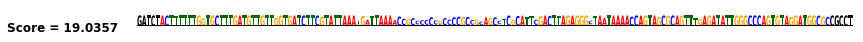

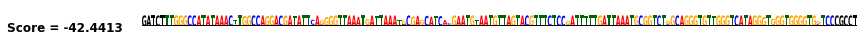

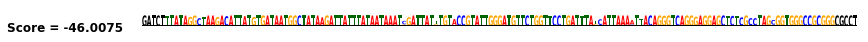

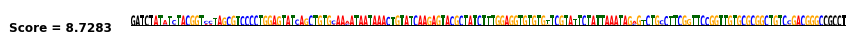

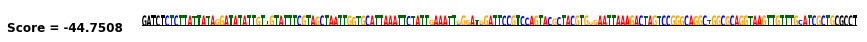

- Real Sequences (Randomly Sampled from Test Set) -


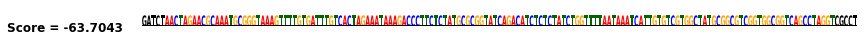

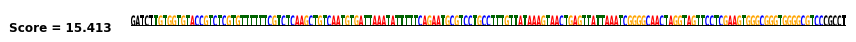

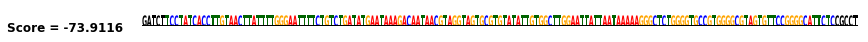

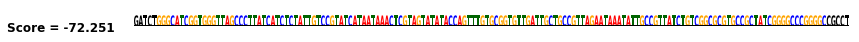

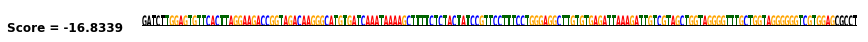

In [23]:
#Visualize a few fake and real sequence patterns

real_scores = []
real_sequences = []
fake_scores = []
fake_pwms = []
fake_sequences = []

for test_index in range(len(data_gens['test'])) :
    real_sequence_batch = data_gens['test'][test_index][0][0]
    real_score_batch = discriminator_model.predict_on_batch([real_sequence_batch])

    class_batch = np.zeros((batch_size, 1), dtype=np.int)
    seed_batch = np.random.normal(loc=0., scale=1., size=(batch_size, 100))

    _, fake_pwm_batch, fake_sequence_batch = generator_model.predict_on_batch([class_batch, seed_batch])
    fake_score_batch = discriminator_model.predict_on_batch([fake_sequence_batch])

    real_scores.append(real_score_batch)
    real_sequences.append(real_sequence_batch)
    fake_scores.append(fake_score_batch)
    fake_pwms.append(fake_pwm_batch)
    fake_sequences.append(fake_sequence_batch)

real_scores = np.concatenate(real_scores, axis=0)
real_sequences = np.concatenate(real_sequences, axis=0)
fake_scores = np.concatenate(fake_scores, axis=0)
fake_pwms = np.concatenate(fake_pwms, axis=0)
fake_sequences = np.concatenate(fake_sequences, axis=0)


print("- Fake Sequences (Randomly Generated) -")

for plot_i in range(5) :
    plot_gan_logo(fake_pwms[plot_i, 0, :, :], fake_scores[plot_i, 0], sequence_template=sequence_templates[0], figsize=(12, 0.55), width_ratios=[1, 7], logo_height=1.0, plot_start=20, plot_end=177)
    #plot_gan_logo(fake_sequences[plot_i, 0, :, :, 0], fake_scores[plot_i, 0, 0], sequence_template=sequence_templates[0], figsize=(12, 0.55), width_ratios=[1, 7], logo_height=1.0, plot_start=20, plot_end=177)

print("- Real Sequences (Randomly Sampled from Test Set) -")

for plot_i in range(5) :
    plot_gan_logo(real_sequences[plot_i, 0, :, :], real_scores[plot_i, 0], sequence_template=sequence_templates[0], figsize=(12, 0.55), width_ratios=[1, 7], logo_height=1.0, plot_start=20, plot_end=177)
